In [ ]:
#!test ! -f "master.zip" && wget "https://github.com/karoldvl/ESC-50/archive/master.zip"

In [ ]:
#!unzip -qq master.zip

In [ ]:
#%cd ESC-50-master

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [ ]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install PyAudio


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libasound2-dev is already the newest version (1.1.3-5ubuntu0.6).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 4 not upgraded.
Need to get 184 kB of archives.
After this operation, 891 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudiocpp0 amd64 19.6.0-1 [15.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 portaudio19-dev amd64 19.6.0-1 [104 kB]
Fetched 184 kB in 1s (185 kB/s)
Selecting pr

In [ ]:
from csv import writer
import pickle
import pyaudio
#import winsound
import wave
import time
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import librosa
import cv2
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm, notebook
import IPython
import os
from google.colab import drive
from numba import cuda

In [ ]:
# import os
# os.environ['PYTORCH_CUDA_ALLOC_CONF']= 'garbage_collection_threshold:0.8'

In [ ]:
prefix= 'drive/Othercomputers/MyPC/R_D/'

In [ ]:
df = pd.read_csv(prefix + 'meta/esc50.csv')
df_extr = pd.read_csv( prefix + 'meta/audio_extr.csv')

In [ ]:
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-3000-E-10.wav,1,NaN,showering,NaN,NaN,NaN
1,1-3001-E-10.wav,1,NaN,showering,NaN,NaN,NaN
2,1-3002-E-10.wav,1,NaN,showering,NaN,NaN,NaN
3,1-3003-E-10.wav,1,NaN,showering,NaN,NaN,NaN
4,1-3004-E-10.wav,1,NaN,showering,NaN,NaN,NaN


In [ ]:
df_extr.head()

,filename,fold,target,category,esc10,src_file,take
0,6-100001-A-1.wav,6,NaN,toilet_flush,NaN,NaN,NaN
1,6-100002-A-1.wav,6,NaN,hands_washing,NaN,NaN,NaN
2,6-100003-A-1.wav,6,NaN,hands_washing,NaN,NaN,NaN
3,6-100004-A-1.wav,6,NaN,showering,NaN,NaN,NaN
4,6-100005-A-1.wav,6,NaN,showering,NaN,NaN,NaN


In [ ]:
df = df.drop(df[(df.category == "dog") | (df.category == "chirping_birds") | (df.category == "thunderstorm") | (df.category == "can_opening") 
                | (df.category == "crow") | (df.category == "clapping") | (df.category == "fireworks") | (df.category == "chainsaw")
                | (df.category == "airplane") | (df.category == "mouse_click") | (df.category == "train") | (df.category == "sheep") 
               | (df.category == "church_bells") | (df.category == "clock_alarm") | (df.category == "keyboard_typing") | (df.category == "wind") 
                | (df.category == "frog") | (df.category == "cow") | (df.category == "car_horn") | (df.category == "crackling_fire") 
                | (df.category == "helicopter") | (df.category == "engine") | (df.category == "pouring_water")  | (df.category == "engine")
               | (df.category == "drinking_sipping") | (df.category == "rain") | (df.category == "insects") | (df.category == "laughing") 
               | (df.category == "hen") | (df.category == "breathing") | (df.category == "crying_baby") | (df.category == "hand_saw")
               | (df.category == "coughing")| (df.category == "insects") | (df.category == "glass_breaking") | (df.category == "snoring")
               | (df.category == "pig") | (df.category == "clock_tick") | (df.category == "footsteps") | (df.category == "rooster")
               | (df.category == "sea_waves") | (df.category == "engine") | (df.category == "sneezing") | (df.category == "siren")
               | (df.category == "cat") | (df.category == "door_wood_creaks") | (df.category == "crickets") | (df.category == "engine")
               | (df.category == "door_wood_knock") | (df.category == "water_drops")].index)
df.reset_index(inplace = True)

In [ ]:
pd.set_option('display.max_rows', None)
print (df['category'])

0            showering
1            showering
2            showering
3            showering
4            showering
5            showering
6            showering
7            showering
8            showering
9            showering
10           showering
11           showering
12      vacuum_cleaner
13      vacuum_cleaner
14      brushing_teeth
15      brushing_teeth
16      vacuum_cleaner
17      vacuum_cleaner
18      vacuum_cleaner
19        toilet_flush
20     washing_machine
21     washing_machine
22     washing_machine
23     washing_machine
24     washing_machine
25        toilet_flush
26        toilet_flush
27     washing_machine
28     washing_machine
29      brushing_teeth
30        toilet_flush
31      vacuum_cleaner
32     washing_machine
33        toilet_flush
34        toilet_flush
35        toilet_flush
36        toilet_flush
37      brushing_teeth
38      brushing_teeth
39      vacuum_cleaner
40      brushing_teeth
41      brushing_teeth
42      brushing_teeth
43      vac

In [ ]:
df = df.drop(['index'], axis='columns') 
df

,filename,fold,target,category,esc10,src_file,take
0,1-3000-E-10.wav,1,NaN,showering,NaN,NaN,NaN
1,1-3001-E-10.wav,1,NaN,showering,NaN,NaN,NaN
2,1-3002-E-10.wav,1,NaN,showering,NaN,NaN,NaN
3,1-3003-E-10.wav,1,NaN,showering,NaN,NaN,NaN
4,1-3004-E-10.wav,1,NaN,showering,NaN,NaN,NaN
5,1-3005-E-10.wav,1,NaN,showering,NaN,NaN,NaN
6,1-3006-E-10.wav,1,NaN,showering,NaN,NaN,NaN
7,1-3007-E-10.wav,1,NaN,showering,NaN,NaN,NaN
8,1-3008-E-10.wav,1,NaN,showering,NaN,NaN,NaN
9,1-3009-E-10.wav,1,NaN,showering,NaN,NaN,NaN


In [ ]:
df1= df['category']== 'showering'
print (df1.value_counts()[True])

47


In [ ]:
print (df['category']== 'showering')

0       True
1       True
2       True
3       True
4       True
5       True
6       True
7       True
8       True
9       True
10      True
11      True
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
30     False
31     False
32     False
33     False
34     False
35     False
36     False
37     False
38     False
39     False
40     False
41     False
42     False
43     False
44      True
45      True
46      True
47      True
48      True
49      True
50      True
51      True
52      True
53      True
54      True
55      True
56      True
57     False
58     False
59     False
60     False
61     False
62     False
63     False
64     False
65     False
66     False
67     False
68     False
69     False
70     False
71     False
72     False
73     False
74     False
75     False
76     False

In [ ]:
df_extr = df_extr.drop(df_extr[(df_extr.category == "hands_washing")].index)

In [ ]:
df_extr.head(40)

,filename,fold,target,category,esc10,src_file,take
0,6-100001-A-1.wav,6,NaN,toilet_flush,NaN,NaN,NaN
3,6-100004-A-1.wav,6,NaN,showering,NaN,NaN,NaN
4,6-100005-A-1.wav,6,NaN,showering,NaN,NaN,NaN
5,6-100006-A-1.wav,6,NaN,vacuum_cleaner,NaN,NaN,NaN
6,6-100007-A-1.wav,6,NaN,vacuum_cleaner,NaN,NaN,NaN
7,6-100008-A-1.wav,6,NaN,brushing_teeth,NaN,NaN,NaN
8,6-100009-A-1.wav,6,NaN,brushing_teeth,NaN,NaN,NaN
9,6-100010-A-1.wav,6,NaN,washing_machine,NaN,NaN,NaN
10,6-100011-A-1.wav,6,NaN,washing_machine,NaN,NaN,NaN
11,6-100012-A-1.wav,6,NaN,toilet_flush,NaN,NaN,NaN


In [ ]:
#if ok merge dataset
df= pd.concat([df, df_extr], ignore_index = True)
df.tail(10)

,filename,fold,target,category,esc10,src_file,take
224,6-100020-A-1.wav,6,NaN,washing_machine,NaN,NaN,NaN
225,6-100021-A-1.wav,6,NaN,toilet_flush,NaN,NaN,NaN
226,6-100022-A-1.wav,6,NaN,showering,NaN,NaN,NaN
227,6-100023-A-1.wav,6,NaN,showering,NaN,NaN,NaN
228,6-100024-A-1.wav,6,NaN,vacuum_cleaner,NaN,NaN,NaN
229,6-100025-A-1.wav,6,NaN,vacuum_cleaner,NaN,NaN,NaN
230,6-100026-A-1.wav,6,NaN,brushing_teeth,NaN,NaN,NaN
231,6-100027-A-1.wav,6,NaN,brushing_teeth,NaN,NaN,NaN
232,6-100028-A-1.wav,6,NaN,washing_machine,NaN,NaN,NaN
233,6-100029-A-1.wav,6,NaN,washing_machine,NaN,NaN,NaN


In [ ]:
df.tail(50)

,filename,fold,target,category,esc10,src_file,take
184,5-182404-A-18.wav,5,18.0,toilet_flush,False,182404.0,A
185,5-185516-A-27.wav,5,27.0,brushing_teeth,False,185516.0,A
186,5-185908-A-18.wav,5,18.0,toilet_flush,False,185908.0,A
187,5-188365-A-36.wav,5,36.0,vacuum_cleaner,False,188365.0,A
188,5-197913-A-18.wav,5,18.0,toilet_flush,False,197913.0,A
189,5-201664-A-18.wav,5,18.0,toilet_flush,False,201664.0,A
190,5-202020-A-18.wav,5,18.0,toilet_flush,False,202020.0,A
191,5-202540-A-18.wav,5,18.0,toilet_flush,False,202540.0,A
192,5-207811-A-35.wav,5,35.0,washing_machine,False,207811.0,A
193,5-207811-B-35.wav,5,35.0,washing_machine,False,207811.0,B


In [ ]:
print (df_extr['category'])

0        toilet_flush
3           showering
4           showering
5      vacuum_cleaner
6      vacuum_cleaner
7      brushing_teeth
8      brushing_teeth
9     washing_machine
10    washing_machine
11       toilet_flush
12          showering
13          showering
14     vacuum_cleaner
15     vacuum_cleaner
16     brushing_teeth
17     brushing_teeth
18    washing_machine
19    washing_machine
20       toilet_flush
21          showering
22          showering
23     vacuum_cleaner
24     vacuum_cleaner
25     brushing_teeth
26     brushing_teeth
27    washing_machine
28    washing_machine
Name: category, dtype: object


In [ ]:
train = df[df['fold']!= 6]
valid = df[df['fold']== 6]

In [ ]:
wav, sr = librosa.load(prefix + 'audio/1-20736-A-18.wav', sr=None)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 44100 and length of the audio is 5.0 seconds


In [ ]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)    
    return spec_scaled

In [ ]:
def spec_to_image_3d(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    # print (np.shape(spec_scaled))
    spec_scaled= cv2.cvtColor(spec_scaled,cv2.COLOR_GRAY2RGB)
    # print (np.shape(spec_scaled))
    return spec_scaled

In [ ]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)
    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    else:
        wav=wav[:5*sr]
    spec=librosa.feature.melspectrogram(y= wav, sr=sr, n_fft=n_fft, hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db

In [ ]:
class ESC50Data(Dataset):
    def __init__(self, base, df, in_col, out_col):
        self.df = df
        self.data = []
        self.temp = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        # print (np.shape(df))        
        self.categories = sorted(df[out_col].unique())
        # print (np.shape(self.categories))
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            file_path = os.path.join(base,row[in_col])
            mel= spec_to_image(get_melspectrogram_db(file_path))
            self.data.append(mel[np.newaxis,...])
            self.labels.append(self.c2i[row['category']])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [ ]:
class ESC50Data_3d(Dataset):
    def __init__(self, base, df, in_col, out_col):
        self.df = df
        self.data = []
        self.temp = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        count= 0
        # print (np.shape(df))        
        self.categories = sorted(df[out_col].unique())
        # print (np.shape(self.categories))
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            file_path = os.path.join(base,row[in_col])
            # print (np.shape(spec_to_image_3d(get_melspectrogram_db(file_path))[...,0]))
            # self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
            mel= spec_to_image_3d(get_melspectrogram_db(file_path))
            mel_0d= mel[...,0]
            mel_1d= mel[...,1]
            mel_2d= mel[...,2]
            self.data.append(mel_0d[np.newaxis,...])
            self.data.append(mel_1d[np.newaxis,...])
            self.data.append(mel_2d[np.newaxis,...])
            self.labels.append(self.c2i[row['category']])
            count+= 1
        self.data= np.reshape(self.data, (count,3, 128, 431))
        
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

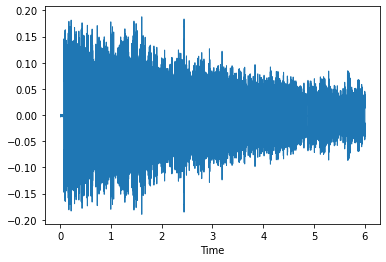

In [ ]:
filename = valid[valid['category']=='toilet_flush'].iloc[0]['filename']
wav, sr = librosa.load(prefix + 'audio/'+filename, sr=None)
librosa.display.waveshow(wav, sr= sr)

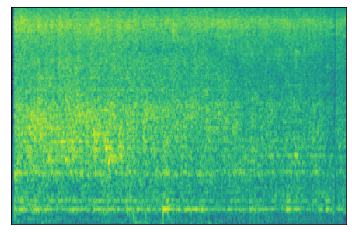

In [ ]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db(prefix + 'audio/'+filename, sr)), cmap='viridis')

In [ ]:
train_data = ESC50Data(prefix + 'audio', train, 'filename', 'category')

100%|██████████| 207/207 [01:24<00:00,  2.46it/s]


In [ ]:
print (np.shape(train_data.data))

(207, 1, 128, 431)


In [ ]:
train_data_3d = ESC50Data_3d(prefix + 'audio', train, 'filename', 'category')

100%|██████████| 207/207 [00:06<00:00, 32.28it/s]


In [ ]:
print (np.shape(train_data_3d.data))

(207, 3, 128, 431)


In [ ]:
valid_data = ESC50Data(prefix + 'audio', valid, 'filename', 'category')

100%|██████████| 27/27 [00:11<00:00,  2.33it/s]


In [ ]:
print (np.shape(valid_data.data))

(27, 1, 128, 431)


In [ ]:
valid_data_3d = ESC50Data_3d(prefix + 'audio', valid, 'filename', 'category')

100%|██████████| 27/27 [00:01<00:00, 24.54it/s]


In [ ]:
print (np.shape(valid_data_3d.data))

(27, 3, 128, 431)


In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=True)
train_loader_3d = DataLoader(train_data_3d, batch_size=32, shuffle=True)
valid_loader_3d = DataLoader(valid_data_3d, batch_size=32, shuffle=True)

In [ ]:
def save_ckp(state, is_best, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    # if it is a best model, min validation loss
    if is_best:
      torch.save(state, best_model_path)

In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath, map_location=torch.device('cpu'))
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer

In [ ]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, best_model_path, change_lr=None):
    valid_loss_min= -1
    for epoch in tqdm(range(1,epochs+1)):
        model.train()
        batch_losses=[]
        if change_lr:
            optimizer = change_lr(optimizer, epoch)
        for i, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        train_losses.append(batch_losses)
        print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
        model.eval()
        batch_losses=[]
        trace_y = []
        trace_yhat = []
        for i, data in enumerate(valid_loader):
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy())      
            batch_losses.append(loss.item())
        valid_losses.append(batch_losses)
        trace_y = np.concatenate(trace_y)
        trace_yhat = np.concatenate(trace_yhat)
        accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)

        checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss_min,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }

        if loss.item() <= valid_loss_min or valid_loss_min== -1:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,loss.item()))
            # save checkpoint as best model
            save_ckp(checkpoint, True, best_model_path)
            valid_loss_min = loss.item()
            
        print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')
    return model

In [ ]:
def setlr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [ ]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

In [ ]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (torch.version.cuda)
print("Device", device)

Is the GPU available? True
11.3
Device cuda:0


In [ ]:
!nvidia-smi -L

GPU 0: A100-SXM4-40GB (UUID: GPU-09ba9b5e-01f1-6c85-d14d-4c7763806a93)


In [ ]:
def free_gpu_cache():
    print("Free GPU Memory...")                           
    torch.cuda.empty_cache()


In [ ]:
free_gpu_cache() 

Free GPU Memory...


In [ ]:
class ESC5Model(nn.Module):
    def __init__(self, input_shape, batch_size=32, num_cats=5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size = 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.conv7 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        self.dense1 = nn.Linear(54272,12800)
        self.dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(12800, num_cats)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = F.max_pool2d(x, kernel_size=2) 
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.conv6(x)
        x = F.relu(self.bn6(x))
        x = F.max_pool2d(x, kernel_size=2)
        # x = self.conv7(x)
        # x = F.relu(self.bn7(x))
        # x = self.conv8(x)
        # x = F.relu(self.bn8(x))
        x = x.view(x.size(0),-1)
        x = F.relu(self.dense1(x))
        # x = self.dropout(x)
        x = self.dense2(x)
        return x


In [ ]:
#custom_model
custom_model = ESC5Model(input_shape=(3,128,431)).to(device)
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(custom_model.parameters(), lr=learning_rate)
epochs = 80
custom_train_losses = []
custom_valid_losses = []

def lr_decay(optimizer, epoch):
    if epoch%40==0:
        new_lr = learning_rate / (10**(epoch//20))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

custom_model= train(custom_model, loss_fn, train_loader_3d, valid_loader_3d, epochs, optimizer, custom_train_losses, custom_valid_losses, 'drive/Othercomputers/MyPC/R_D/models/custom.pth', lr_decay)

In [ ]:
tl = np.asarray(custom_train_losses).ravel()
vl = np.asarray(custom_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [ ]:
vgg_model_19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
#VGG19
from torchvision.models import vgg19, VGG19_Weights
weights = VGG19_Weights.DEFAULT
vgg_model_19 = vgg19(weights=weights)
# vgg_model_19 = vgg19()
# vgg_model_19.fc = nn.Linear(512,50)
# vgg_model_19.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_classes = 5
num_ftrs= 4096
vgg_model_19.classifier[6]= nn.Linear(num_ftrs, num_classes)
learning_rate = 2e-4
optimizer = optim.Adam(vgg_model_19.parameters(), lr=learning_rate)

In [ ]:
vgg_model_19 = vgg_model_19.to(device)
epochs = 80
loss_fn = nn.CrossEntropyLoss()
vgg_19_train_losses=[]
vgg_19_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%80==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

vgg_model_19 = train(vgg_model_19, loss_fn, train_loader_3d, valid_loader_3d, epochs, optimizer, vgg_19_train_losses, vgg_19_valid_losses, 'drive/Othercomputers/MyPC/R_D/models/vgg_19.pth', lr_decay)

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 2.6313213961465016
Validation loss decreased (-1.000000 --> 1.589435).  Saving model ...


  1%|▏         | 1/80 [00:05<06:47,  5.16s/it]

Epoch - 1 Valid-Loss : 1.5894345045089722 Valid-Accuracy : 0.2222222222222222
Epoch - 2 Train-Loss : 1.635850429534912
Validation loss decreased (1.589435 --> 1.531134).  Saving model ...


  2%|▎         | 2/80 [00:10<06:58,  5.37s/it]

Epoch - 2 Valid-Loss : 1.531133770942688 Valid-Accuracy : 0.4074074074074074


  4%|▍         | 3/80 [00:11<04:08,  3.22s/it]

Epoch - 3 Train-Loss : 1.360738524368831
Epoch - 3 Valid-Loss : 1.6169466972351074 Valid-Accuracy : 0.2962962962962963


  5%|▌         | 4/80 [00:11<02:47,  2.21s/it]

Epoch - 4 Train-Loss : 1.511243394442967
Epoch - 4 Valid-Loss : 1.631537914276123 Valid-Accuracy : 0.37037037037037035


  6%|▋         | 5/80 [00:12<02:03,  1.65s/it]

Epoch - 5 Train-Loss : 1.1170532022203719
Epoch - 5 Valid-Loss : 2.396846294403076 Valid-Accuracy : 0.4074074074074074


  8%|▊         | 6/80 [00:13<01:36,  1.31s/it]

Epoch - 6 Train-Loss : 1.2133548089436121
Epoch - 6 Valid-Loss : 1.9414262771606445 Valid-Accuracy : 0.48148148148148145


  9%|▉         | 7/80 [00:13<01:19,  1.09s/it]

Epoch - 7 Train-Loss : 0.922952013356345
Epoch - 7 Valid-Loss : 1.9427748918533325 Valid-Accuracy : 0.3333333333333333


 10%|█         | 8/80 [00:14<01:08,  1.05it/s]

Epoch - 8 Train-Loss : 0.7425693699291774
Epoch - 8 Valid-Loss : 3.1378843784332275 Valid-Accuracy : 0.37037037037037035


 11%|█▏        | 9/80 [00:15<01:00,  1.17it/s]

Epoch - 9 Train-Loss : 0.7348097137042454
Epoch - 9 Valid-Loss : 3.8772687911987305 Valid-Accuracy : 0.37037037037037035


 12%|█▎        | 10/80 [00:15<00:55,  1.27it/s]

Epoch - 10 Train-Loss : 0.4511758323226656
Epoch - 10 Valid-Loss : 3.9124324321746826 Valid-Accuracy : 0.4074074074074074


 14%|█▍        | 11/80 [00:16<00:51,  1.34it/s]

Epoch - 11 Train-Loss : 0.28695634433201384
Epoch - 11 Valid-Loss : 9.18511962890625 Valid-Accuracy : 0.37037037037037035


 15%|█▌        | 12/80 [00:17<00:48,  1.40it/s]

Epoch - 12 Train-Loss : 0.8841691357748849
Epoch - 12 Valid-Loss : 3.5127322673797607 Valid-Accuracy : 0.3333333333333333


 16%|█▋        | 13/80 [00:17<00:46,  1.45it/s]

Epoch - 13 Train-Loss : 0.43746099727494375
Epoch - 13 Valid-Loss : 2.943948745727539 Valid-Accuracy : 0.3333333333333333


 18%|█▊        | 14/80 [00:18<00:44,  1.48it/s]

Epoch - 14 Train-Loss : 0.2679071937288557
Epoch - 14 Valid-Loss : 5.578582763671875 Valid-Accuracy : 0.4074074074074074


 19%|█▉        | 15/80 [00:19<00:43,  1.51it/s]

Epoch - 15 Train-Loss : 0.2764678288783346
Epoch - 15 Valid-Loss : 2.464308500289917 Valid-Accuracy : 0.5555555555555556


 20%|██        | 16/80 [00:19<00:41,  1.52it/s]

Epoch - 16 Train-Loss : 0.1629353759012052
Epoch - 16 Valid-Loss : 2.6472368240356445 Valid-Accuracy : 0.6296296296296297


 21%|██▏       | 17/80 [00:20<00:40,  1.54it/s]

Epoch - 17 Train-Loss : 0.051806844238724024
Epoch - 17 Valid-Loss : 7.646630764007568 Valid-Accuracy : 0.4074074074074074


 22%|██▎       | 18/80 [00:20<00:40,  1.55it/s]

Epoch - 18 Train-Loss : 0.14728975899717106
Epoch - 18 Valid-Loss : 4.561176776885986 Valid-Accuracy : 0.5185185185185185


 24%|██▍       | 19/80 [00:21<00:39,  1.55it/s]

Epoch - 19 Train-Loss : 0.8980518324034554
Epoch - 19 Valid-Loss : 2.34983491897583 Valid-Accuracy : 0.37037037037037035


 25%|██▌       | 20/80 [00:22<00:38,  1.56it/s]

Epoch - 20 Train-Loss : 0.5265945983784539
Epoch - 20 Valid-Loss : 2.870558738708496 Valid-Accuracy : 0.48148148148148145


 26%|██▋       | 21/80 [00:22<00:37,  1.56it/s]

Epoch - 21 Train-Loss : 0.18926630382026946
Epoch - 21 Valid-Loss : 4.646952152252197 Valid-Accuracy : 0.5185185185185185


 28%|██▊       | 22/80 [00:23<00:37,  1.56it/s]

Epoch - 22 Train-Loss : 0.08832629876477378
Epoch - 22 Valid-Loss : 2.912020444869995 Valid-Accuracy : 0.5185185185185185


 29%|██▉       | 23/80 [00:24<00:36,  1.56it/s]

Epoch - 23 Train-Loss : 0.06876641358914119
Epoch - 23 Valid-Loss : 8.346519470214844 Valid-Accuracy : 0.4444444444444444


 30%|███       | 24/80 [00:24<00:35,  1.56it/s]

Epoch - 24 Train-Loss : 0.04690648542184915
Epoch - 24 Valid-Loss : 4.392043590545654 Valid-Accuracy : 0.6296296296296297


 31%|███▏      | 25/80 [00:25<00:35,  1.55it/s]

Epoch - 25 Train-Loss : 0.03842756416166334
Epoch - 25 Valid-Loss : 8.797592163085938 Valid-Accuracy : 0.48148148148148145


 32%|███▎      | 26/80 [00:26<00:34,  1.55it/s]

Epoch - 26 Train-Loss : 0.21888498930327063
Epoch - 26 Valid-Loss : 4.029871463775635 Valid-Accuracy : 0.4444444444444444


 34%|███▍      | 27/80 [00:26<00:34,  1.55it/s]

Epoch - 27 Train-Loss : 0.13372282071837358
Epoch - 27 Valid-Loss : 3.320918083190918 Valid-Accuracy : 0.4444444444444444


 35%|███▌      | 28/80 [00:27<00:33,  1.55it/s]

Epoch - 28 Train-Loss : 0.19093944132328033
Epoch - 28 Valid-Loss : 2.7990808486938477 Valid-Accuracy : 0.4074074074074074


 36%|███▋      | 29/80 [00:28<00:32,  1.55it/s]

Epoch - 29 Train-Loss : 0.0645492332322257
Epoch - 29 Valid-Loss : 4.161252498626709 Valid-Accuracy : 0.48148148148148145


 38%|███▊      | 30/80 [00:28<00:32,  1.55it/s]

Epoch - 30 Train-Loss : 0.5099416535397593
Epoch - 30 Valid-Loss : 5.73878288269043 Valid-Accuracy : 0.5185185185185185
Epoch - 31 Train-Loss : 0.3142826565142189
Validation loss decreased (1.531134 --> 1.376938).  Saving model ...


 39%|███▉      | 31/80 [00:34<01:43,  2.10s/it]

Epoch - 31 Valid-Loss : 1.376937985420227 Valid-Accuracy : 0.6666666666666666


 40%|████      | 32/80 [00:34<01:20,  1.68s/it]

Epoch - 32 Train-Loss : 1.2119347623416357
Epoch - 32 Valid-Loss : 3.0641610622406006 Valid-Accuracy : 0.3333333333333333


 41%|████▏     | 33/80 [00:35<01:04,  1.36s/it]

Epoch - 33 Train-Loss : 0.8198683559894562
Epoch - 33 Valid-Loss : 3.4481022357940674 Valid-Accuracy : 0.5925925925925926


 42%|████▎     | 34/80 [00:36<00:52,  1.15s/it]

Epoch - 34 Train-Loss : 0.3718224912881851
Epoch - 34 Valid-Loss : 8.914901733398438 Valid-Accuracy : 0.48148148148148145


 44%|████▍     | 35/80 [00:36<00:44,  1.00it/s]

Epoch - 35 Train-Loss : 0.22388064861297607
Epoch - 35 Valid-Loss : 2.5718448162078857 Valid-Accuracy : 0.7037037037037037


 45%|████▌     | 36/80 [00:37<00:39,  1.12it/s]

Epoch - 36 Train-Loss : 0.232520868735654
Epoch - 36 Valid-Loss : 7.888269424438477 Valid-Accuracy : 0.6296296296296297


 46%|████▋     | 37/80 [00:38<00:35,  1.22it/s]

Epoch - 37 Train-Loss : 0.3655263004558427
Epoch - 37 Valid-Loss : 3.0055954456329346 Valid-Accuracy : 0.6296296296296297


 48%|████▊     | 38/80 [00:38<00:32,  1.31it/s]

Epoch - 38 Train-Loss : 0.32069849967956543
Epoch - 38 Valid-Loss : 2.442937135696411 Valid-Accuracy : 0.6296296296296297


 49%|████▉     | 39/80 [00:39<00:29,  1.37it/s]

Epoch - 39 Train-Loss : 0.14621856808662415
Epoch - 39 Valid-Loss : 2.9008119106292725 Valid-Accuracy : 0.6296296296296297


 50%|█████     | 40/80 [00:40<00:28,  1.42it/s]

Epoch - 40 Train-Loss : 0.06356519241152066
Epoch - 40 Valid-Loss : 4.27422571182251 Valid-Accuracy : 0.6296296296296297


 51%|█████▏    | 41/80 [00:40<00:26,  1.46it/s]

Epoch - 41 Train-Loss : 0.04350689332932234
Epoch - 41 Valid-Loss : 9.76579761505127 Valid-Accuracy : 0.7037037037037037


 52%|█████▎    | 42/80 [00:41<00:25,  1.48it/s]

Epoch - 42 Train-Loss : 0.11833462509925344
Epoch - 42 Valid-Loss : 13.085772514343262 Valid-Accuracy : 0.6666666666666666


 54%|█████▍    | 43/80 [00:41<00:24,  1.51it/s]

Epoch - 43 Train-Loss : 4.47289701551199
Epoch - 43 Valid-Loss : 1.774592399597168 Valid-Accuracy : 0.2222222222222222


 55%|█████▌    | 44/80 [00:42<00:23,  1.52it/s]

Epoch - 44 Train-Loss : 1.1119925720351083
Epoch - 44 Valid-Loss : 1.5261805057525635 Valid-Accuracy : 0.48148148148148145


 56%|█████▋    | 45/80 [00:43<00:22,  1.53it/s]

Epoch - 45 Train-Loss : 0.9060719779559544
Epoch - 45 Valid-Loss : 1.5242376327514648 Valid-Accuracy : 0.5185185185185185


 57%|█████▊    | 46/80 [00:43<00:22,  1.53it/s]

Epoch - 46 Train-Loss : 1.1694352797099523
Epoch - 46 Valid-Loss : 1.700615644454956 Valid-Accuracy : 0.3333333333333333


 59%|█████▉    | 47/80 [00:44<00:21,  1.54it/s]

Epoch - 47 Train-Loss : 1.2595216546739851
Epoch - 47 Valid-Loss : 1.6149739027023315 Valid-Accuracy : 0.25925925925925924


 60%|██████    | 48/80 [00:45<00:20,  1.54it/s]

Epoch - 48 Train-Loss : 1.1925358176231384
Epoch - 48 Valid-Loss : 1.4028903245925903 Valid-Accuracy : 0.2222222222222222


 61%|██████▏   | 49/80 [00:45<00:20,  1.55it/s]

Epoch - 49 Train-Loss : 0.9225219317844936
Epoch - 49 Valid-Loss : 1.5173156261444092 Valid-Accuracy : 0.4444444444444444
Epoch - 50 Train-Loss : 0.8488009912627084
Validation loss decreased (1.376938 --> 1.190511).  Saving model ...


 62%|██████▎   | 50/80 [00:51<01:02,  2.09s/it]

Epoch - 50 Valid-Loss : 1.1905105113983154 Valid-Accuracy : 0.5555555555555556


 64%|██████▍   | 51/80 [00:51<00:48,  1.66s/it]

Epoch - 51 Train-Loss : 0.7804607493536813
Epoch - 51 Valid-Loss : 2.1284666061401367 Valid-Accuracy : 0.3333333333333333


 65%|██████▌   | 52/80 [00:52<00:37,  1.35s/it]

Epoch - 52 Train-Loss : 1.4555301410811288
Epoch - 52 Valid-Loss : 3.50246262550354 Valid-Accuracy : 0.5185185185185185


 66%|██████▋   | 53/80 [00:53<00:30,  1.14s/it]

Epoch - 53 Train-Loss : 1.4839648348944527
Epoch - 53 Valid-Loss : 1.6275864839553833 Valid-Accuracy : 0.2222222222222222


 68%|██████▊   | 54/80 [00:53<00:25,  1.01it/s]

Epoch - 54 Train-Loss : 1.2828326054981776
Epoch - 54 Valid-Loss : 1.521608829498291 Valid-Accuracy : 0.2222222222222222


 69%|██████▉   | 55/80 [00:54<00:22,  1.13it/s]

Epoch - 55 Train-Loss : 1.272032959120614
Epoch - 55 Valid-Loss : 1.204201340675354 Valid-Accuracy : 0.5185185185185185


 70%|███████   | 56/80 [00:55<00:19,  1.24it/s]

Epoch - 56 Train-Loss : 1.3728852442332677
Epoch - 56 Valid-Loss : 1.4138014316558838 Valid-Accuracy : 0.48148148148148145


 71%|███████▏  | 57/80 [00:55<00:17,  1.32it/s]

Epoch - 57 Train-Loss : 1.2078602143696375
Epoch - 57 Valid-Loss : 1.3721787929534912 Valid-Accuracy : 0.37037037037037035


 72%|███████▎  | 58/80 [00:56<00:15,  1.39it/s]

Epoch - 58 Train-Loss : 0.9483535545212882
Epoch - 58 Valid-Loss : 1.5656256675720215 Valid-Accuracy : 0.2962962962962963


 74%|███████▍  | 59/80 [00:57<00:14,  1.44it/s]

Epoch - 59 Train-Loss : 0.9604733501161847
Epoch - 59 Valid-Loss : 2.900177001953125 Valid-Accuracy : 0.25925925925925924


 75%|███████▌  | 60/80 [00:57<00:13,  1.46it/s]

Epoch - 60 Train-Loss : 0.9026116558483669
Epoch - 60 Valid-Loss : 1.3605093955993652 Valid-Accuracy : 0.5185185185185185


 76%|███████▋  | 61/80 [00:58<00:12,  1.49it/s]

Epoch - 61 Train-Loss : 1.8019306404250008
Epoch - 61 Valid-Loss : 1.3510780334472656 Valid-Accuracy : 0.2962962962962963


 78%|███████▊  | 62/80 [00:58<00:11,  1.50it/s]

Epoch - 62 Train-Loss : 1.353668281010219
Epoch - 62 Valid-Loss : 1.3342058658599854 Valid-Accuracy : 0.4444444444444444


 79%|███████▉  | 63/80 [00:59<00:11,  1.52it/s]

Epoch - 63 Train-Loss : 1.2369451182229179
Epoch - 63 Valid-Loss : 1.4380584955215454 Valid-Accuracy : 0.4074074074074074


 80%|████████  | 64/80 [01:00<00:10,  1.53it/s]

Epoch - 64 Train-Loss : 1.0638375793184554
Epoch - 64 Valid-Loss : 1.446343183517456 Valid-Accuracy : 0.4074074074074074


 81%|████████▏ | 65/80 [01:00<00:09,  1.54it/s]

Epoch - 65 Train-Loss : 1.1661167740821838
Epoch - 65 Valid-Loss : 2.0375173091888428 Valid-Accuracy : 0.2962962962962963


 82%|████████▎ | 66/80 [01:01<00:09,  1.54it/s]

Epoch - 66 Train-Loss : 1.1258338519505091
Epoch - 66 Valid-Loss : 2.209489107131958 Valid-Accuracy : 0.2222222222222222


 84%|████████▍ | 67/80 [01:02<00:08,  1.55it/s]

Epoch - 67 Train-Loss : 1.051773990903582
Epoch - 67 Valid-Loss : 1.4839873313903809 Valid-Accuracy : 0.4444444444444444
Epoch - 68 Train-Loss : 0.8459199156079974
Validation loss decreased (1.190511 --> 1.163895).  Saving model ...


 85%|████████▌ | 68/80 [01:07<00:25,  2.13s/it]

Epoch - 68 Valid-Loss : 1.1638948917388916 Valid-Accuracy : 0.5185185185185185


 86%|████████▋ | 69/80 [01:08<00:18,  1.69s/it]

Epoch - 69 Train-Loss : 0.7027678319386074
Epoch - 69 Valid-Loss : 1.3198456764221191 Valid-Accuracy : 0.4074074074074074


 88%|████████▊ | 70/80 [01:09<00:13,  1.38s/it]

Epoch - 70 Train-Loss : 0.5979973077774048
Epoch - 70 Valid-Loss : 2.2339580059051514 Valid-Accuracy : 0.4074074074074074


 89%|████████▉ | 71/80 [01:09<00:10,  1.15s/it]

Epoch - 71 Train-Loss : 0.5999740362167358
Epoch - 71 Valid-Loss : 2.613316059112549 Valid-Accuracy : 0.4444444444444444


 90%|█████████ | 72/80 [01:10<00:08,  1.00s/it]

Epoch - 72 Train-Loss : 0.6452416607311794
Epoch - 72 Valid-Loss : 2.7466540336608887 Valid-Accuracy : 0.4074074074074074


 91%|█████████▏| 73/80 [01:11<00:06,  1.12it/s]

Epoch - 73 Train-Loss : 0.9809025951794216
Epoch - 73 Valid-Loss : 3.686497449874878 Valid-Accuracy : 0.25925925925925924


 92%|█████████▎| 74/80 [01:11<00:04,  1.22it/s]

Epoch - 74 Train-Loss : 0.8914847203663417
Epoch - 74 Valid-Loss : 2.1925294399261475 Valid-Accuracy : 0.3333333333333333


 94%|█████████▍| 75/80 [01:12<00:03,  1.31it/s]

Epoch - 75 Train-Loss : 0.7828357943466732
Epoch - 75 Valid-Loss : 4.408049583435059 Valid-Accuracy : 0.2222222222222222


 95%|█████████▌| 76/80 [01:12<00:02,  1.37it/s]

Epoch - 76 Train-Loss : 0.6821939817496708
Epoch - 76 Valid-Loss : 3.0177297592163086 Valid-Accuracy : 0.48148148148148145


 96%|█████████▋| 77/80 [01:13<00:02,  1.42it/s]

Epoch - 77 Train-Loss : 0.7942657385553632
Epoch - 77 Valid-Loss : 2.548915147781372 Valid-Accuracy : 0.48148148148148145


 98%|█████████▊| 78/80 [01:14<00:01,  1.46it/s]

Epoch - 78 Train-Loss : 0.565081890140261
Epoch - 78 Valid-Loss : 6.194316387176514 Valid-Accuracy : 0.3333333333333333


 99%|█████████▉| 79/80 [01:14<00:00,  1.49it/s]

Epoch - 79 Train-Loss : 0.5656447964055198
Epoch - 79 Valid-Loss : 6.066690921783447 Valid-Accuracy : 0.3333333333333333
Changed learning rate to 2e-12


100%|██████████| 80/80 [01:15<00:00,  1.06it/s]

Epoch - 80 Train-Loss : 0.5664325824805668
Epoch - 80 Valid-Loss : 6.066690921783447 Valid-Accuracy : 0.3333333333333333


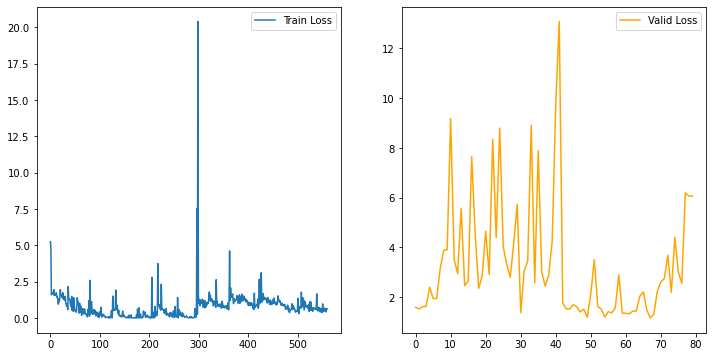

In [ ]:
tl = np.asarray(vgg_19_train_losses).ravel()
vl = np.asarray(vgg_19_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

In [ ]:
alexnet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#AlexNet
from torchvision.models import alexnet, AlexNet_Weights
weights = AlexNet_Weights.DEFAULT
alexnet_model = alexnet(weights=weights)
#alexnet_model = alexnet()
# alexnet_model.fc = nn.Linear(512,50)
# alexnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_classes = 5
num_ftrs= 4096
alexnet_model.classifier[6]= nn.Linear(num_ftrs, num_classes)
learning_rate = 2e-4
optimizer = optim.Adam(alexnet_model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
alexnet_model = alexnet_model.to(device)
epochs = 80
loss_fn = nn.CrossEntropyLoss()
alexnet_train_losses=[]
alexnet_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%80==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

alexnet_model = train(alexnet_model, loss_fn, train_loader_3d, valid_loader_3d, epochs, optimizer, alexnet_train_losses, alexnet_valid_losses, 'drive/Othercomputers/MyPC/R_D/models/alexnet.pth', lr_decay)

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 4.179303203310285
Validation loss decreased (-1.000000 --> 1.193682).  Saving model ...


  1%|▏         | 1/80 [00:01<02:25,  1.84s/it]

Epoch - 1 Valid-Loss : 1.193682312965393 Valid-Accuracy : 0.5925925925925926
Epoch - 2 Train-Loss : 0.8825055871691022
Validation loss decreased (1.193682 --> 0.623405).  Saving model ...


  4%|▍         | 3/80 [00:03<01:25,  1.11s/it]

Epoch - 2 Valid-Loss : 0.6234050393104553 Valid-Accuracy : 0.8148148148148148
Epoch - 3 Train-Loss : 0.6191142840044839
Epoch - 3 Valid-Loss : 2.121951103210449 Valid-Accuracy : 0.6296296296296297


  6%|▋         | 5/80 [00:04<00:38,  1.97it/s]

Epoch - 4 Train-Loss : 0.5493124340261731
Epoch - 4 Valid-Loss : 1.967668056488037 Valid-Accuracy : 0.7037037037037037
Epoch - 5 Train-Loss : 0.34370833209582735
Epoch - 5 Valid-Loss : 1.3486162424087524 Valid-Accuracy : 0.5555555555555556


  9%|▉         | 7/80 [00:04<00:21,  3.40it/s]

Epoch - 6 Train-Loss : 0.40828305802174975
Epoch - 6 Valid-Loss : 1.9756274223327637 Valid-Accuracy : 0.5925925925925926
Epoch - 7 Train-Loss : 0.23017039895057678
Epoch - 7 Valid-Loss : 3.4068987369537354 Valid-Accuracy : 0.48148148148148145


 11%|█▏        | 9/80 [00:04<00:14,  4.93it/s]

Epoch - 8 Train-Loss : 0.23522034606763295
Epoch - 8 Valid-Loss : 0.8758605718612671 Valid-Accuracy : 0.6296296296296297
Epoch - 9 Train-Loss : 0.21132597792893648
Epoch - 9 Valid-Loss : 3.4046518802642822 Valid-Accuracy : 0.5925925925925926


 14%|█▍        | 11/80 [00:04<00:11,  6.15it/s]

Epoch - 10 Train-Loss : 0.14081526866980962
Epoch - 10 Valid-Loss : 2.3468680381774902 Valid-Accuracy : 0.5925925925925926
Epoch - 11 Train-Loss : 0.16308288276195526
Epoch - 11 Valid-Loss : 4.302127361297607 Valid-Accuracy : 0.6296296296296297


 16%|█▋        | 13/80 [00:05<00:09,  7.04it/s]

Epoch - 12 Train-Loss : 0.08263080368383921
Epoch - 12 Valid-Loss : 3.4652252197265625 Valid-Accuracy : 0.6296296296296297
Epoch - 13 Train-Loss : 0.06692362697867793
Epoch - 13 Valid-Loss : 3.536118745803833 Valid-Accuracy : 0.6666666666666666


 19%|█▉        | 15/80 [00:05<00:08,  7.45it/s]

Epoch - 14 Train-Loss : 0.27650224563798736
Epoch - 14 Valid-Loss : 5.98956298828125 Valid-Accuracy : 0.5185185185185185
Epoch - 15 Train-Loss : 0.31587531164820704
Epoch - 15 Valid-Loss : 3.4488277435302734 Valid-Accuracy : 0.6296296296296297


 21%|██▏       | 17/80 [00:05<00:08,  7.79it/s]

Epoch - 16 Train-Loss : 0.34273551198254737
Epoch - 16 Valid-Loss : 5.071817398071289 Valid-Accuracy : 0.5185185185185185
Epoch - 17 Train-Loss : 0.28203183518988745
Epoch - 17 Valid-Loss : 2.6996874809265137 Valid-Accuracy : 0.6296296296296297


 24%|██▍       | 19/80 [00:05<00:07,  7.90it/s]

Epoch - 18 Train-Loss : 0.19479455200156995
Epoch - 18 Valid-Loss : 2.372959613800049 Valid-Accuracy : 0.7407407407407407
Epoch - 19 Train-Loss : 0.23861622777102248
Epoch - 19 Valid-Loss : 2.9189817905426025 Valid-Accuracy : 0.6296296296296297


 26%|██▋       | 21/80 [00:06<00:07,  8.03it/s]

Epoch - 20 Train-Loss : 0.21058295215230569
Epoch - 20 Valid-Loss : 3.9597108364105225 Valid-Accuracy : 0.5925925925925926
Epoch - 21 Train-Loss : 0.2546788640320301
Epoch - 21 Valid-Loss : 5.275218963623047 Valid-Accuracy : 0.48148148148148145


 29%|██▉       | 23/80 [00:06<00:07,  8.00it/s]

Epoch - 22 Train-Loss : 0.22893674405557768
Epoch - 22 Valid-Loss : 3.0684170722961426 Valid-Accuracy : 0.6296296296296297
Epoch - 23 Train-Loss : 0.27705401541399105
Epoch - 23 Valid-Loss : 2.5500335693359375 Valid-Accuracy : 0.6666666666666666


 31%|███▏      | 25/80 [00:06<00:06,  8.13it/s]

Epoch - 24 Train-Loss : 0.22782889221395766
Epoch - 24 Valid-Loss : 3.805572986602783 Valid-Accuracy : 0.6296296296296297
Epoch - 25 Train-Loss : 0.12713882220642908
Epoch - 25 Valid-Loss : 2.733459234237671 Valid-Accuracy : 0.6666666666666666


 34%|███▍      | 27/80 [00:06<00:06,  8.22it/s]

Epoch - 26 Train-Loss : 0.14722440990486316
Epoch - 26 Valid-Loss : 4.9373626708984375 Valid-Accuracy : 0.5185185185185185
Epoch - 27 Train-Loss : 0.1871592535504273
Epoch - 27 Valid-Loss : 3.378657102584839 Valid-Accuracy : 0.48148148148148145


 36%|███▋      | 29/80 [00:07<00:06,  8.27it/s]

Epoch - 28 Train-Loss : 0.09000127922211375
Epoch - 28 Valid-Loss : 1.4526342153549194 Valid-Accuracy : 0.5925925925925926
Epoch - 29 Train-Loss : 0.05849301314135248
Epoch - 29 Valid-Loss : 4.687465190887451 Valid-Accuracy : 0.48148148148148145


 39%|███▉      | 31/80 [00:07<00:05,  8.27it/s]

Epoch - 30 Train-Loss : 0.04291408249576177
Epoch - 30 Valid-Loss : 2.4997873306274414 Valid-Accuracy : 0.6296296296296297
Epoch - 31 Train-Loss : 0.04463244567159563
Epoch - 31 Valid-Loss : 3.9987826347351074 Valid-Accuracy : 0.6296296296296297


 41%|████▏     | 33/80 [00:07<00:05,  8.29it/s]

Epoch - 32 Train-Loss : 0.025221137013951584
Epoch - 32 Valid-Loss : 4.832845211029053 Valid-Accuracy : 0.5555555555555556
Epoch - 33 Train-Loss : 0.023897822554967467
Epoch - 33 Valid-Loss : 4.495425224304199 Valid-Accuracy : 0.5555555555555556


 44%|████▍     | 35/80 [00:07<00:05,  8.24it/s]

Epoch - 34 Train-Loss : 0.0010246758564400288
Epoch - 34 Valid-Loss : 3.293168783187866 Valid-Accuracy : 0.6666666666666666
Epoch - 35 Train-Loss : 0.007108354624636247
Epoch - 35 Valid-Loss : 4.221441268920898 Valid-Accuracy : 0.5555555555555556


 46%|████▋     | 37/80 [00:08<00:05,  8.24it/s]

Epoch - 36 Train-Loss : 0.005332371631603954
Epoch - 36 Valid-Loss : 5.442539691925049 Valid-Accuracy : 0.5555555555555556
Epoch - 37 Train-Loss : 0.03063619233944337
Epoch - 37 Valid-Loss : 3.1129775047302246 Valid-Accuracy : 0.6296296296296297


 49%|████▉     | 39/80 [00:08<00:04,  8.24it/s]

Epoch - 38 Train-Loss : 0.04911496059607349
Epoch - 38 Valid-Loss : 2.925335645675659 Valid-Accuracy : 0.6296296296296297
Epoch - 39 Train-Loss : 0.06893286044110677
Epoch - 39 Valid-Loss : 3.161217212677002 Valid-Accuracy : 0.6296296296296297


 51%|█████▏    | 41/80 [00:08<00:04,  8.29it/s]

Epoch - 40 Train-Loss : 0.016041782607187218
Epoch - 40 Valid-Loss : 2.4313509464263916 Valid-Accuracy : 0.7037037037037037
Epoch - 41 Train-Loss : 0.041936836554668844
Epoch - 41 Valid-Loss : 2.8820858001708984 Valid-Accuracy : 0.7407407407407407


 54%|█████▍    | 43/80 [00:08<00:04,  8.21it/s]

Epoch - 42 Train-Loss : 0.002855601120440302
Epoch - 42 Valid-Loss : 3.9211390018463135 Valid-Accuracy : 0.6296296296296297
Epoch - 43 Train-Loss : 0.013482515804493491
Epoch - 43 Valid-Loss : 3.389995813369751 Valid-Accuracy : 0.7407407407407407


 56%|█████▋    | 45/80 [00:09<00:04,  8.10it/s]

Epoch - 44 Train-Loss : 0.0004360444398920598
Epoch - 44 Valid-Loss : 3.08170747756958 Valid-Accuracy : 0.7777777777777778
Epoch - 45 Train-Loss : 0.0035661911270779
Epoch - 45 Valid-Loss : 3.4644744396209717 Valid-Accuracy : 0.7407407407407407


 59%|█████▉    | 47/80 [00:09<00:04,  8.12it/s]

Epoch - 46 Train-Loss : 0.00019304633354165292
Epoch - 46 Valid-Loss : 3.991974353790283 Valid-Accuracy : 0.7407407407407407
Epoch - 47 Train-Loss : 0.023400089405348417
Epoch - 47 Valid-Loss : 3.068247079849243 Valid-Accuracy : 0.5925925925925926


 61%|██████▏   | 49/80 [00:09<00:03,  8.04it/s]

Epoch - 48 Train-Loss : 0.05372946203111541
Epoch - 48 Valid-Loss : 6.067651271820068 Valid-Accuracy : 0.5555555555555556
Epoch - 49 Train-Loss : 0.5002418245588031
Epoch - 49 Valid-Loss : 0.7534725666046143 Valid-Accuracy : 0.6666666666666666


 64%|██████▍   | 51/80 [00:09<00:03,  7.83it/s]

Epoch - 50 Train-Loss : 0.29053506148712976
Epoch - 50 Valid-Loss : 2.540295124053955 Valid-Accuracy : 0.5925925925925926
Epoch - 51 Train-Loss : 0.21098906984220125
Epoch - 51 Valid-Loss : 3.675856113433838 Valid-Accuracy : 0.5185185185185185


 66%|██████▋   | 53/80 [00:10<00:03,  7.99it/s]

Epoch - 52 Train-Loss : 0.2406124042879258
Epoch - 52 Valid-Loss : 2.147764205932617 Valid-Accuracy : 0.6296296296296297
Epoch - 53 Train-Loss : 0.18788284276212966
Epoch - 53 Valid-Loss : 3.245192289352417 Valid-Accuracy : 0.5925925925925926


 69%|██████▉   | 55/80 [00:10<00:03,  8.04it/s]

Epoch - 54 Train-Loss : 0.4415413143662071
Epoch - 54 Valid-Loss : 1.720655083656311 Valid-Accuracy : 0.5925925925925926
Epoch - 55 Train-Loss : 0.3701823449560574
Epoch - 55 Valid-Loss : 1.2449368238449097 Valid-Accuracy : 0.5555555555555556


 71%|███████▏  | 57/80 [00:10<00:03,  7.66it/s]

Epoch - 56 Train-Loss : 0.13430167946665147
Epoch - 56 Valid-Loss : 1.9419190883636475 Valid-Accuracy : 0.5555555555555556
Epoch - 57 Train-Loss : 0.23656203890485422
Epoch - 57 Valid-Loss : 1.9467664957046509 Valid-Accuracy : 0.5555555555555556


 74%|███████▍  | 59/80 [00:10<00:02,  7.58it/s]

Epoch - 58 Train-Loss : 0.06707814655133656
Epoch - 58 Valid-Loss : 2.398890972137451 Valid-Accuracy : 0.5185185185185185
Epoch - 59 Train-Loss : 0.0342662599203842
Epoch - 59 Valid-Loss : 2.5373709201812744 Valid-Accuracy : 0.5555555555555556


 76%|███████▋  | 61/80 [00:11<00:02,  7.68it/s]

Epoch - 60 Train-Loss : 0.027981276025197337
Epoch - 60 Valid-Loss : 3.2220585346221924 Valid-Accuracy : 0.5925925925925926
Epoch - 61 Train-Loss : 0.014183753905984173
Epoch - 61 Valid-Loss : 3.24588942527771 Valid-Accuracy : 0.7037037037037037


 79%|███████▉  | 63/80 [00:11<00:02,  7.79it/s]

Epoch - 62 Train-Loss : 0.013317162279106145
Epoch - 62 Valid-Loss : 3.582185983657837 Valid-Accuracy : 0.6666666666666666
Epoch - 63 Train-Loss : 0.001352837007808765
Epoch - 63 Valid-Loss : 6.250481128692627 Valid-Accuracy : 0.4444444444444444


 81%|████████▏ | 65/80 [00:11<00:01,  7.78it/s]

Epoch - 64 Train-Loss : 0.043760912551078945
Epoch - 64 Valid-Loss : 4.065250873565674 Valid-Accuracy : 0.6296296296296297
Epoch - 65 Train-Loss : 0.012308563190734796
Epoch - 65 Valid-Loss : 4.55000114440918 Valid-Accuracy : 0.6666666666666666


 84%|████████▍ | 67/80 [00:11<00:01,  7.60it/s]

Epoch - 66 Train-Loss : 0.046519696267718506
Epoch - 66 Valid-Loss : 6.452063083648682 Valid-Accuracy : 0.5555555555555556
Epoch - 67 Train-Loss : 0.013504843970232676
Epoch - 67 Valid-Loss : 5.056634902954102 Valid-Accuracy : 0.5925925925925926


 86%|████████▋ | 69/80 [00:12<00:01,  7.77it/s]

Epoch - 68 Train-Loss : 0.001904957312571501
Epoch - 68 Valid-Loss : 4.060932636260986 Valid-Accuracy : 0.6296296296296297
Epoch - 69 Train-Loss : 0.004800072745768246
Epoch - 69 Valid-Loss : 4.056786060333252 Valid-Accuracy : 0.5555555555555556


 89%|████████▉ | 71/80 [00:12<00:01,  7.78it/s]

Epoch - 70 Train-Loss : 0.021769486091216095
Epoch - 70 Valid-Loss : 6.349545955657959 Valid-Accuracy : 0.4444444444444444
Epoch - 71 Train-Loss : 0.08693882054441408
Epoch - 71 Valid-Loss : 3.8708698749542236 Valid-Accuracy : 0.6296296296296297


 91%|█████████▏| 73/80 [00:12<00:00,  7.88it/s]

Epoch - 72 Train-Loss : 0.09779734778151448
Epoch - 72 Valid-Loss : 3.580454111099243 Valid-Accuracy : 0.6666666666666666
Epoch - 73 Train-Loss : 0.04847559081723115
Epoch - 73 Valid-Loss : 6.785540580749512 Valid-Accuracy : 0.48148148148148145


 94%|█████████▍| 75/80 [00:12<00:00,  7.86it/s]

Epoch - 74 Train-Loss : 0.007107948706496765
Epoch - 74 Valid-Loss : 3.5356991291046143 Valid-Accuracy : 0.7037037037037037
Epoch - 75 Train-Loss : 0.06829142239907274
Epoch - 75 Valid-Loss : 8.452468872070312 Valid-Accuracy : 0.48148148148148145


 96%|█████████▋| 77/80 [00:13<00:00,  7.65it/s]

Epoch - 76 Train-Loss : 0.16786521433719567
Epoch - 76 Valid-Loss : 1.8774621486663818 Valid-Accuracy : 0.5555555555555556
Epoch - 77 Train-Loss : 0.11757078074983188
Epoch - 77 Valid-Loss : 3.6008548736572266 Valid-Accuracy : 0.4444444444444444


 99%|█████████▉| 79/80 [00:13<00:00,  7.78it/s]

Epoch - 78 Train-Loss : 0.04295745936022805
Epoch - 78 Valid-Loss : 3.3272793292999268 Valid-Accuracy : 0.5555555555555556
Epoch - 79 Train-Loss : 0.17306805087719113
Epoch - 79 Valid-Loss : 8.86910629272461 Valid-Accuracy : 0.48148148148148145
Changed learning rate to 2e-12


100%|██████████| 80/80 [00:13<00:00,  5.87it/s]

Epoch - 80 Train-Loss : 0.4171976872270794
Epoch - 80 Valid-Loss : 8.869105339050293 Valid-Accuracy : 0.48148148148148145


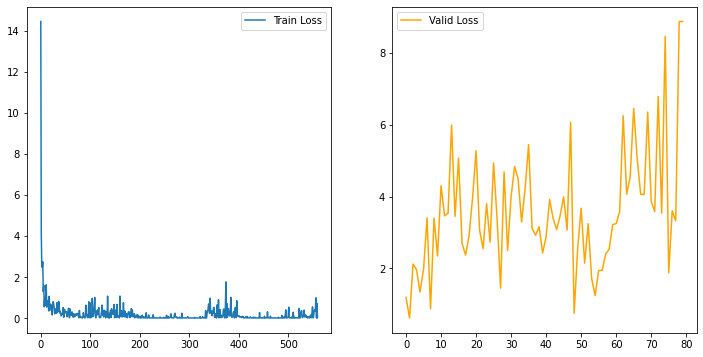

In [ ]:
tl = np.asarray(alexnet_train_losses).ravel()
vl = np.asarray(alexnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

In [ ]:
resnet_model_152

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#ResNet152
from torchvision.models import resnet152, ResNet152_Weights
weights = ResNet152_Weights.DEFAULT
resnet_model_152 = resnet152(weights=weights)
#resnet_model_152 = resnet34()
# resnet_model_152.fc = nn.Linear(512,50)
# resnet_model_152.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_classes = 5
num_ftrs= 2048
resnet_model_152.fc= nn.Linear(num_ftrs, num_classes)
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model_152.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
resnet_model_152 = resnet_model_152.to(device)
epochs = 80
loss_fn = nn.CrossEntropyLoss()
resnet_152_train_losses=[]
resnet_152_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%50==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

resnet_model_152 = train(resnet_model_152, loss_fn, train_loader_3d, valid_loader_3d, epochs, optimizer, resnet_152_train_losses, resnet_152_valid_losses, 'drive/Othercomputers/MyPC/R_D/models/resnet152.pth', lr_decay)

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 1.4798441955021449
Validation loss decreased (-1.000000 --> 1.560088).  Saving model ...


  1%|▏         | 1/80 [00:06<08:12,  6.23s/it]

Epoch - 1 Valid-Loss : 1.5600883960723877 Valid-Accuracy : 0.25925925925925924
Epoch - 2 Train-Loss : 0.8348192487444196
Validation loss decreased (1.560088 --> 1.246461).  Saving model ...


  2%|▎         | 2/80 [00:09<05:52,  4.52s/it]

Epoch - 2 Valid-Loss : 1.2464613914489746 Valid-Accuracy : 0.48148148148148145
Epoch - 3 Train-Loss : 0.2530241140297481
Validation loss decreased (1.246461 --> 0.934389).  Saving model ...


  4%|▍         | 3/80 [00:12<05:09,  4.02s/it]

Epoch - 3 Valid-Loss : 0.9343888759613037 Valid-Accuracy : 0.5555555555555556


  5%|▌         | 4/80 [00:14<03:40,  2.90s/it]

Epoch - 4 Train-Loss : 0.06049613082515342
Epoch - 4 Valid-Loss : 1.0848816633224487 Valid-Accuracy : 0.6666666666666666


  6%|▋         | 5/80 [00:15<02:50,  2.27s/it]

Epoch - 5 Train-Loss : 0.017264254191624268
Epoch - 5 Valid-Loss : 1.7839722633361816 Valid-Accuracy : 0.5925925925925926


  8%|▊         | 6/80 [00:16<02:19,  1.89s/it]

Epoch - 6 Train-Loss : 0.004674884390884212
Epoch - 6 Valid-Loss : 1.872552514076233 Valid-Accuracy : 0.6296296296296297


  9%|▉         | 7/80 [00:17<02:00,  1.64s/it]

Epoch - 7 Train-Loss : 0.00484276154643989
Epoch - 7 Valid-Loss : 1.5236589908599854 Valid-Accuracy : 0.6296296296296297


 10%|█         | 8/80 [00:18<01:47,  1.49s/it]

Epoch - 8 Train-Loss : 0.015403461151955915
Epoch - 8 Valid-Loss : 1.0916647911071777 Valid-Accuracy : 0.6666666666666666


 11%|█▏        | 9/80 [00:19<01:38,  1.38s/it]

Epoch - 9 Train-Loss : 0.1028821324996118
Epoch - 9 Valid-Loss : 1.0819905996322632 Valid-Accuracy : 0.6666666666666666
Epoch - 10 Train-Loss : 0.03368081438488194
Validation loss decreased (0.934389 --> 0.856545).  Saving model ...


 12%|█▎        | 10/80 [00:23<02:21,  2.02s/it]

Epoch - 10 Valid-Loss : 0.8565448522567749 Valid-Accuracy : 0.6296296296296297
Epoch - 11 Train-Loss : 0.07127883790859155
Validation loss decreased (0.856545 --> 0.701676).  Saving model ...


 14%|█▍        | 11/80 [00:26<02:43,  2.37s/it]

Epoch - 11 Valid-Loss : 0.7016758918762207 Valid-Accuracy : 0.7037037037037037


 15%|█▌        | 12/80 [00:27<02:15,  2.00s/it]

Epoch - 12 Train-Loss : 0.036021102885050435
Epoch - 12 Valid-Loss : 0.8346524238586426 Valid-Accuracy : 0.7037037037037037


 16%|█▋        | 13/80 [00:28<01:56,  1.74s/it]

Epoch - 13 Train-Loss : 0.023335591091641357
Epoch - 13 Valid-Loss : 0.7718621492385864 Valid-Accuracy : 0.7407407407407407
Epoch - 14 Train-Loss : 0.007090288280908551
Validation loss decreased (0.701676 --> 0.680790).  Saving model ...


 18%|█▊        | 14/80 [00:33<02:44,  2.50s/it]

Epoch - 14 Valid-Loss : 0.6807898879051208 Valid-Accuracy : 0.7777777777777778


 19%|█▉        | 15/80 [00:34<02:15,  2.09s/it]

Epoch - 15 Train-Loss : 0.024252054314794286
Epoch - 15 Valid-Loss : 0.6850765347480774 Valid-Accuracy : 0.7407407407407407


 20%|██        | 16/80 [00:35<01:55,  1.81s/it]

Epoch - 16 Train-Loss : 0.023397903623325483
Epoch - 16 Valid-Loss : 0.7030541896820068 Valid-Accuracy : 0.7407407407407407


 21%|██▏       | 17/80 [00:36<01:41,  1.60s/it]

Epoch - 17 Train-Loss : 0.002460441352533443
Epoch - 17 Valid-Loss : 0.9091664552688599 Valid-Accuracy : 0.7037037037037037


 22%|██▎       | 18/80 [00:37<01:30,  1.46s/it]

Epoch - 18 Train-Loss : 0.01121215578833861
Epoch - 18 Valid-Loss : 0.8574657440185547 Valid-Accuracy : 0.7407407407407407


 24%|██▍       | 19/80 [00:38<01:23,  1.37s/it]

Epoch - 19 Train-Loss : 0.059352377230035405
Epoch - 19 Valid-Loss : 0.7010306119918823 Valid-Accuracy : 0.6666666666666666


 25%|██▌       | 20/80 [00:39<01:18,  1.30s/it]

Epoch - 20 Train-Loss : 0.02419466964368309
Epoch - 20 Valid-Loss : 1.246589183807373 Valid-Accuracy : 0.5555555555555556


 26%|██▋       | 21/80 [00:41<01:14,  1.26s/it]

Epoch - 21 Train-Loss : 0.007321025311414685
Epoch - 21 Valid-Loss : 1.0740426778793335 Valid-Accuracy : 0.5925925925925926


 28%|██▊       | 22/80 [00:42<01:10,  1.22s/it]

Epoch - 22 Train-Loss : 0.009409550677186676
Epoch - 22 Valid-Loss : 0.8640404343605042 Valid-Accuracy : 0.6666666666666666


 29%|██▉       | 23/80 [00:43<01:08,  1.20s/it]

Epoch - 23 Train-Loss : 0.009975757732588266
Epoch - 23 Valid-Loss : 0.9080379009246826 Valid-Accuracy : 0.6296296296296297


 30%|███       | 24/80 [00:44<01:06,  1.18s/it]

Epoch - 24 Train-Loss : 0.004859960978917245
Epoch - 24 Valid-Loss : 1.2435808181762695 Valid-Accuracy : 0.7037037037037037


 31%|███▏      | 25/80 [00:45<01:05,  1.19s/it]

Epoch - 25 Train-Loss : 0.049035504435388635
Epoch - 25 Valid-Loss : 1.8908971548080444 Valid-Accuracy : 0.5925925925925926


 32%|███▎      | 26/80 [00:46<01:04,  1.19s/it]

Epoch - 26 Train-Loss : 0.03556020563701168
Epoch - 26 Valid-Loss : 1.082929015159607 Valid-Accuracy : 0.7037037037037037


 34%|███▍      | 27/80 [00:48<01:03,  1.19s/it]

Epoch - 27 Train-Loss : 0.01591959539135652
Epoch - 27 Valid-Loss : 0.8887488842010498 Valid-Accuracy : 0.7037037037037037


 35%|███▌      | 28/80 [00:49<01:01,  1.19s/it]

Epoch - 28 Train-Loss : 0.016033808343178992
Epoch - 28 Valid-Loss : 1.2069571018218994 Valid-Accuracy : 0.6296296296296297


 36%|███▋      | 29/80 [00:50<01:00,  1.19s/it]

Epoch - 29 Train-Loss : 0.004596062029512333
Epoch - 29 Valid-Loss : 1.9547861814498901 Valid-Accuracy : 0.6296296296296297
Changed learning rate to 2.0000000000000002e-07


 38%|███▊      | 30/80 [00:51<01:00,  1.20s/it]

Epoch - 30 Train-Loss : 0.006473053862074656
Epoch - 30 Valid-Loss : 1.6527303457260132 Valid-Accuracy : 0.6666666666666666


 39%|███▉      | 31/80 [00:52<00:58,  1.19s/it]

Epoch - 31 Train-Loss : 0.009249016667516636
Epoch - 31 Valid-Loss : 1.4467358589172363 Valid-Accuracy : 0.7037037037037037


 40%|████      | 32/80 [00:54<00:57,  1.20s/it]

Epoch - 32 Train-Loss : 0.00442233493751181
Epoch - 32 Valid-Loss : 1.3351656198501587 Valid-Accuracy : 0.7037037037037037


 41%|████▏     | 33/80 [00:55<00:56,  1.20s/it]

Epoch - 33 Train-Loss : 0.0022196186806208323
Epoch - 33 Valid-Loss : 1.303533911705017 Valid-Accuracy : 0.7037037037037037


 42%|████▎     | 34/80 [00:56<00:55,  1.21s/it]

Epoch - 34 Train-Loss : 0.027902216064311296
Epoch - 34 Valid-Loss : 1.3220796585083008 Valid-Accuracy : 0.6666666666666666


 44%|████▍     | 35/80 [00:57<00:53,  1.20s/it]

Epoch - 35 Train-Loss : 0.004526904875612152
Epoch - 35 Valid-Loss : 1.2603981494903564 Valid-Accuracy : 0.7037037037037037


 45%|████▌     | 36/80 [00:58<00:51,  1.18s/it]

Epoch - 36 Train-Loss : 0.00362812469912959
Epoch - 36 Valid-Loss : 1.3242837190628052 Valid-Accuracy : 0.6666666666666666


 46%|████▋     | 37/80 [00:59<00:50,  1.17s/it]

Epoch - 37 Train-Loss : 0.006948102839357618
Epoch - 37 Valid-Loss : 1.2920236587524414 Valid-Accuracy : 0.7037037037037037


 48%|████▊     | 38/80 [01:01<00:48,  1.16s/it]

Epoch - 38 Train-Loss : 0.004101989291874426
Epoch - 38 Valid-Loss : 1.258352518081665 Valid-Accuracy : 0.7037037037037037


 49%|████▉     | 39/80 [01:02<00:47,  1.16s/it]

Epoch - 39 Train-Loss : 0.005574285651424101
Epoch - 39 Valid-Loss : 1.3028595447540283 Valid-Accuracy : 0.7037037037037037


 50%|█████     | 40/80 [01:03<00:45,  1.15s/it]

Epoch - 40 Train-Loss : 0.0024248670171281056
Epoch - 40 Valid-Loss : 1.3498808145523071 Valid-Accuracy : 0.6666666666666666


 51%|█████▏    | 41/80 [01:04<00:44,  1.15s/it]

Epoch - 41 Train-Loss : 0.0015104959020391107
Epoch - 41 Valid-Loss : 1.3301774263381958 Valid-Accuracy : 0.7037037037037037


 52%|█████▎    | 42/80 [01:05<00:43,  1.14s/it]

Epoch - 42 Train-Loss : 0.003674041962118021
Epoch - 42 Valid-Loss : 1.3124349117279053 Valid-Accuracy : 0.7037037037037037


 54%|█████▍    | 43/80 [01:06<00:42,  1.14s/it]

Epoch - 43 Train-Loss : 0.005013761676049658
Epoch - 43 Valid-Loss : 1.2019392251968384 Valid-Accuracy : 0.7037037037037037


 55%|█████▌    | 44/80 [01:07<00:40,  1.13s/it]

Epoch - 44 Train-Loss : 0.007765619766100177
Epoch - 44 Valid-Loss : 1.2936514616012573 Valid-Accuracy : 0.7037037037037037


 56%|█████▋    | 45/80 [01:09<00:39,  1.13s/it]

Epoch - 45 Train-Loss : 0.00510140391997993
Epoch - 45 Valid-Loss : 1.2070565223693848 Valid-Accuracy : 0.7037037037037037


 57%|█████▊    | 46/80 [01:10<00:38,  1.14s/it]

Epoch - 46 Train-Loss : 0.002562339650467038
Epoch - 46 Valid-Loss : 1.1390682458877563 Valid-Accuracy : 0.7037037037037037


 59%|█████▉    | 47/80 [01:11<00:37,  1.14s/it]

Epoch - 47 Train-Loss : 0.0050223005237057805
Epoch - 47 Valid-Loss : 1.2783628702163696 Valid-Accuracy : 0.7037037037037037


 60%|██████    | 48/80 [01:12<00:36,  1.14s/it]

Epoch - 48 Train-Loss : 0.007464984182401427
Epoch - 48 Valid-Loss : 1.3286443948745728 Valid-Accuracy : 0.7037037037037037


 61%|██████▏   | 49/80 [01:13<00:35,  1.14s/it]

Epoch - 49 Train-Loss : 0.025480483018327504
Epoch - 49 Valid-Loss : 1.347409725189209 Valid-Accuracy : 0.7037037037037037


 62%|██████▎   | 50/80 [01:14<00:34,  1.14s/it]

Epoch - 50 Train-Loss : 0.0029839890277279274
Epoch - 50 Valid-Loss : 1.3764724731445312 Valid-Accuracy : 0.6666666666666666


 64%|██████▍   | 51/80 [01:15<00:33,  1.14s/it]

Epoch - 51 Train-Loss : 0.004780437597738845
Epoch - 51 Valid-Loss : 1.2958954572677612 Valid-Accuracy : 0.6666666666666666


 65%|██████▌   | 52/80 [01:17<00:31,  1.14s/it]

Epoch - 52 Train-Loss : 0.006092991280768599
Epoch - 52 Valid-Loss : 1.1906404495239258 Valid-Accuracy : 0.6666666666666666


 66%|██████▋   | 53/80 [01:18<00:30,  1.14s/it]

Epoch - 53 Train-Loss : 0.0025894365639292766
Epoch - 53 Valid-Loss : 1.217265248298645 Valid-Accuracy : 0.6666666666666666


 68%|██████▊   | 54/80 [01:19<00:29,  1.13s/it]

Epoch - 54 Train-Loss : 0.0024460528178938796
Epoch - 54 Valid-Loss : 1.1860400438308716 Valid-Accuracy : 0.7037037037037037


 69%|██████▉   | 55/80 [01:20<00:28,  1.14s/it]

Epoch - 55 Train-Loss : 0.0025985979342034887
Epoch - 55 Valid-Loss : 1.220361590385437 Valid-Accuracy : 0.7037037037037037


 70%|███████   | 56/80 [01:21<00:27,  1.14s/it]

Epoch - 56 Train-Loss : 0.0071340296251167145
Epoch - 56 Valid-Loss : 1.1774832010269165 Valid-Accuracy : 0.7037037037037037


 71%|███████▏  | 57/80 [01:22<00:26,  1.14s/it]

Epoch - 57 Train-Loss : 0.008842418943199195
Epoch - 57 Valid-Loss : 1.1920158863067627 Valid-Accuracy : 0.7037037037037037


 72%|███████▎  | 58/80 [01:23<00:25,  1.14s/it]

Epoch - 58 Train-Loss : 0.0041831753915175796
Epoch - 58 Valid-Loss : 1.2484078407287598 Valid-Accuracy : 0.6666666666666666


 74%|███████▍  | 59/80 [01:25<00:23,  1.14s/it]

Epoch - 59 Train-Loss : 0.0036164993653073907
Epoch - 59 Valid-Loss : 1.3037991523742676 Valid-Accuracy : 0.6666666666666666
Changed learning rate to 2e-10


 75%|███████▌  | 60/80 [01:26<00:22,  1.14s/it]

Epoch - 60 Train-Loss : 0.0047755799854972535
Epoch - 60 Valid-Loss : 1.2987009286880493 Valid-Accuracy : 0.6666666666666666


 76%|███████▋  | 61/80 [01:27<00:21,  1.13s/it]

Epoch - 61 Train-Loss : 0.006813676063237446
Epoch - 61 Valid-Loss : 1.250001072883606 Valid-Accuracy : 0.7037037037037037


 78%|███████▊  | 62/80 [01:28<00:20,  1.13s/it]

Epoch - 62 Train-Loss : 0.007080796706889357
Epoch - 62 Valid-Loss : 1.2295516729354858 Valid-Accuracy : 0.6666666666666666


 79%|███████▉  | 63/80 [01:29<00:19,  1.13s/it]

Epoch - 63 Train-Loss : 0.008430398002799069
Epoch - 63 Valid-Loss : 1.3023066520690918 Valid-Accuracy : 0.6666666666666666


 80%|████████  | 64/80 [01:30<00:18,  1.14s/it]

Epoch - 64 Train-Loss : 0.018550582063783492
Epoch - 64 Valid-Loss : 1.2670923471450806 Valid-Accuracy : 0.7037037037037037


 81%|████████▏ | 65/80 [01:31<00:17,  1.14s/it]

Epoch - 65 Train-Loss : 0.0032712286504517707
Epoch - 65 Valid-Loss : 1.207409143447876 Valid-Accuracy : 0.7037037037037037


 82%|████████▎ | 66/80 [01:32<00:15,  1.14s/it]

Epoch - 66 Train-Loss : 0.004749449801498226
Epoch - 66 Valid-Loss : 1.3644506931304932 Valid-Accuracy : 0.7037037037037037


 84%|████████▍ | 67/80 [01:34<00:14,  1.14s/it]

Epoch - 67 Train-Loss : 0.022536523141232983
Epoch - 67 Valid-Loss : 1.3469988107681274 Valid-Accuracy : 0.7037037037037037


 85%|████████▌ | 68/80 [01:35<00:13,  1.14s/it]

Epoch - 68 Train-Loss : 0.010257536096365325
Epoch - 68 Valid-Loss : 1.4026000499725342 Valid-Accuracy : 0.7037037037037037


 86%|████████▋ | 69/80 [01:36<00:12,  1.13s/it]

Epoch - 69 Train-Loss : 0.0034772875951603055
Epoch - 69 Valid-Loss : 1.4324053525924683 Valid-Accuracy : 0.7037037037037037


 88%|████████▊ | 70/80 [01:37<00:11,  1.13s/it]

Epoch - 70 Train-Loss : 0.004506630606816283
Epoch - 70 Valid-Loss : 1.4370676279067993 Valid-Accuracy : 0.6666666666666666


 89%|████████▉ | 71/80 [01:38<00:10,  1.14s/it]

Epoch - 71 Train-Loss : 0.004905081836373678
Epoch - 71 Valid-Loss : 1.3601588010787964 Valid-Accuracy : 0.7037037037037037


 90%|█████████ | 72/80 [01:39<00:09,  1.14s/it]

Epoch - 72 Train-Loss : 0.003412718651816249
Epoch - 72 Valid-Loss : 1.2774629592895508 Valid-Accuracy : 0.7037037037037037


 91%|█████████▏| 73/80 [01:40<00:07,  1.14s/it]

Epoch - 73 Train-Loss : 0.006446413113735616
Epoch - 73 Valid-Loss : 1.301128625869751 Valid-Accuracy : 0.7037037037037037


 92%|█████████▎| 74/80 [01:42<00:06,  1.14s/it]

Epoch - 74 Train-Loss : 0.011598479767729129
Epoch - 74 Valid-Loss : 1.3491379022598267 Valid-Accuracy : 0.6666666666666666


 94%|█████████▍| 75/80 [01:43<00:05,  1.13s/it]

Epoch - 75 Train-Loss : 0.005744610879836338
Epoch - 75 Valid-Loss : 1.2785671949386597 Valid-Accuracy : 0.6666666666666666


 95%|█████████▌| 76/80 [01:44<00:04,  1.14s/it]

Epoch - 76 Train-Loss : 0.002914749435149133
Epoch - 76 Valid-Loss : 1.3112831115722656 Valid-Accuracy : 0.7037037037037037


 96%|█████████▋| 77/80 [01:45<00:03,  1.14s/it]

Epoch - 77 Train-Loss : 0.0023833983660941677
Epoch - 77 Valid-Loss : 1.3756555318832397 Valid-Accuracy : 0.6666666666666666


 98%|█████████▊| 78/80 [01:46<00:02,  1.14s/it]

Epoch - 78 Train-Loss : 0.002450360184801476
Epoch - 78 Valid-Loss : 1.370064377784729 Valid-Accuracy : 0.7037037037037037


 99%|█████████▉| 79/80 [01:47<00:01,  1.14s/it]

Epoch - 79 Train-Loss : 0.023063347042937363
Epoch - 79 Valid-Loss : 1.3278905153274536 Valid-Accuracy : 0.6666666666666666


100%|██████████| 80/80 [01:48<00:00,  1.36s/it]

Epoch - 80 Train-Loss : 0.007657236477825791
Epoch - 80 Valid-Loss : 1.268656849861145 Valid-Accuracy : 0.6666666666666666


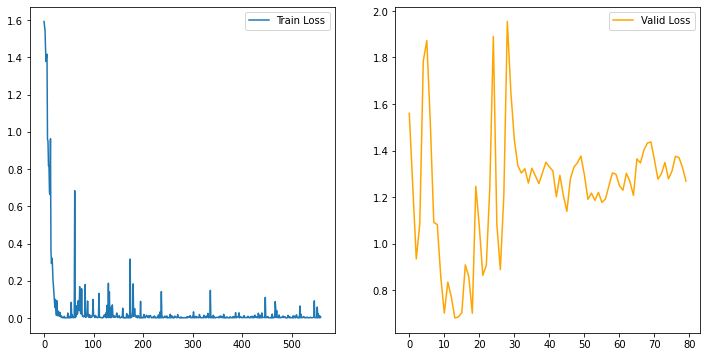

In [ ]:
tl = np.asarray(resnet_152_train_losses).ravel()
vl = np.asarray(resnet_152_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [ ]:
resnet_model_50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#ResNet50
from torchvision.models import resnet50, ResNet50_Weights
weights = ResNet50_Weights.DEFAULT
resnet_model_50 = resnet50(weights=weights)
# resnet_model_50 = resnet50()
# resnet_model_50.fc = nn.Linear(2048,16)
# resnet_model_50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding= (2, 2), bias=False)
num_classes = 5
num_ftrs= 2048
resnet_model_50.fc= nn.Linear(num_ftrs, num_classes)
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model_50.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
learning_rate = 2e-4
resnet_model_50 = resnet_model_50.to(device)
epochs = 80
loss_fn = nn.CrossEntropyLoss()
resnet_50_train_losses=[]
resnet_50_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%50==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

resnet_model_50 = train(resnet_model_50, loss_fn, train_loader_3d, valid_loader_3d, epochs, optimizer, resnet_50_train_losses, resnet_50_valid_losses, 'drive/Othercomputers/MyPC/R_D/models/resnet50.pth', lr_decay)

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 0.007583802358047771
Validation loss decreased (-1.000000 --> 1.091252).  Saving model ...


  1%|▏         | 1/80 [00:01<01:42,  1.30s/it]

Epoch - 1 Valid-Loss : 1.0912524461746216 Valid-Accuracy : 0.8518518518518519


  2%|▎         | 2/80 [00:01<01:04,  1.20it/s]

Epoch - 2 Train-Loss : 0.0019591404831901726
Epoch - 2 Valid-Loss : 1.0916452407836914 Valid-Accuracy : 0.8148148148148148
Epoch - 3 Train-Loss : 0.0009830855830971683
Validation loss decreased (1.091252 --> 1.066196).  Saving model ...


  4%|▍         | 3/80 [00:03<01:21,  1.06s/it]

Epoch - 3 Valid-Loss : 1.0661962032318115 Valid-Accuracy : 0.8148148148148148


  5%|▌         | 4/80 [00:03<01:03,  1.19it/s]

Epoch - 4 Train-Loss : 0.0011899858821249967
Epoch - 4 Valid-Loss : 1.1057088375091553 Valid-Accuracy : 0.8148148148148148


  6%|▋         | 5/80 [00:04<00:53,  1.39it/s]

Epoch - 5 Train-Loss : 0.002514527894423476
Epoch - 5 Valid-Loss : 1.1529721021652222 Valid-Accuracy : 0.8148148148148148
Epoch - 6 Train-Loss : 0.001301345371757634
Validation loss decreased (1.066196 --> 1.034458).  Saving model ...


  8%|▊         | 6/80 [00:05<01:08,  1.08it/s]

Epoch - 6 Valid-Loss : 1.0344576835632324 Valid-Accuracy : 0.8148148148148148


  9%|▉         | 7/80 [00:05<00:57,  1.27it/s]

Epoch - 7 Train-Loss : 0.005816055320402873
Epoch - 7 Valid-Loss : 1.0381869077682495 Valid-Accuracy : 0.8518518518518519


 10%|█         | 8/80 [00:06<00:50,  1.43it/s]

Epoch - 8 Train-Loss : 0.0014617905045659946
Epoch - 8 Valid-Loss : 1.0890535116195679 Valid-Accuracy : 0.8518518518518519


 11%|█▏        | 9/80 [00:06<00:45,  1.56it/s]

Epoch - 9 Train-Loss : 0.0014845411808762168
Epoch - 9 Valid-Loss : 1.04180109500885 Valid-Accuracy : 0.8518518518518519


 12%|█▎        | 10/80 [00:07<00:42,  1.66it/s]

Epoch - 10 Train-Loss : 0.003630119951724607
Epoch - 10 Valid-Loss : 1.104477882385254 Valid-Accuracy : 0.7777777777777778


 14%|█▍        | 11/80 [00:08<00:39,  1.75it/s]

Epoch - 11 Train-Loss : 0.001006554695777595
Epoch - 11 Valid-Loss : 1.1449049711227417 Valid-Accuracy : 0.8148148148148148


 15%|█▌        | 12/80 [00:08<00:37,  1.81it/s]

Epoch - 12 Train-Loss : 0.0020604068870722714
Epoch - 12 Valid-Loss : 1.1462900638580322 Valid-Accuracy : 0.7777777777777778


 16%|█▋        | 13/80 [00:09<00:36,  1.86it/s]

Epoch - 13 Train-Loss : 0.004248182561631049
Epoch - 13 Valid-Loss : 1.1278563737869263 Valid-Accuracy : 0.8148148148148148


 18%|█▊        | 14/80 [00:09<00:35,  1.87it/s]

Epoch - 14 Train-Loss : 0.0015253549957248782
Epoch - 14 Valid-Loss : 1.1354026794433594 Valid-Accuracy : 0.8148148148148148


 19%|█▉        | 15/80 [00:10<00:34,  1.91it/s]

Epoch - 15 Train-Loss : 0.0014179659441911749
Epoch - 15 Valid-Loss : 1.0489683151245117 Valid-Accuracy : 0.8518518518518519
Epoch - 16 Train-Loss : 0.0016573737271495961
Validation loss decreased (1.034458 --> 0.983936).  Saving model ...


 20%|██        | 16/80 [00:11<00:49,  1.30it/s]

Epoch - 16 Valid-Loss : 0.9839357733726501 Valid-Accuracy : 0.8518518518518519


 21%|██▏       | 17/80 [00:11<00:43,  1.45it/s]

Epoch - 17 Train-Loss : 0.0011695648635005845
Epoch - 17 Valid-Loss : 1.1498048305511475 Valid-Accuracy : 0.8148148148148148


 22%|██▎       | 18/80 [00:12<00:39,  1.59it/s]

Epoch - 18 Train-Loss : 0.002565144536284996
Epoch - 18 Valid-Loss : 1.0427910089492798 Valid-Accuracy : 0.8518518518518519


 24%|██▍       | 19/80 [00:12<00:36,  1.69it/s]

Epoch - 19 Train-Loss : 0.0012770085335692524
Epoch - 19 Valid-Loss : 1.054321527481079 Valid-Accuracy : 0.8148148148148148


 25%|██▌       | 20/80 [00:13<00:34,  1.76it/s]

Epoch - 20 Train-Loss : 0.010832425994781911
Epoch - 20 Valid-Loss : 1.1853692531585693 Valid-Accuracy : 0.7407407407407407


 26%|██▋       | 21/80 [00:13<00:32,  1.82it/s]

Epoch - 21 Train-Loss : 0.008367931807047821
Epoch - 21 Valid-Loss : 1.1866562366485596 Valid-Accuracy : 0.7777777777777778


 28%|██▊       | 22/80 [00:14<00:30,  1.88it/s]

Epoch - 22 Train-Loss : 0.001754505917363401
Epoch - 22 Valid-Loss : 1.157436490058899 Valid-Accuracy : 0.8148148148148148


 29%|██▉       | 23/80 [00:14<00:29,  1.91it/s]

Epoch - 23 Train-Loss : 0.001469092967454344
Epoch - 23 Valid-Loss : 1.1370759010314941 Valid-Accuracy : 0.8148148148148148


 30%|███       | 24/80 [00:15<00:28,  1.94it/s]

Epoch - 24 Train-Loss : 0.001045903521506781
Epoch - 24 Valid-Loss : 1.047858715057373 Valid-Accuracy : 0.8518518518518519


 31%|███▏      | 25/80 [00:15<00:28,  1.96it/s]

Epoch - 25 Train-Loss : 0.005119436027598567
Epoch - 25 Valid-Loss : 1.1261125802993774 Valid-Accuracy : 0.7777777777777778


 32%|███▎      | 26/80 [00:16<00:27,  1.97it/s]

Epoch - 26 Train-Loss : 0.0010282068147457071
Epoch - 26 Valid-Loss : 1.1690068244934082 Valid-Accuracy : 0.8148148148148148


 34%|███▍      | 27/80 [00:16<00:26,  1.98it/s]

Epoch - 27 Train-Loss : 0.0023922663697573754
Epoch - 27 Valid-Loss : 1.1324082612991333 Valid-Accuracy : 0.8148148148148148


 35%|███▌      | 28/80 [00:17<00:26,  1.99it/s]

Epoch - 28 Train-Loss : 0.0007471164613629558
Epoch - 28 Valid-Loss : 1.0726433992385864 Valid-Accuracy : 0.8148148148148148


 36%|███▋      | 29/80 [00:17<00:25,  2.00it/s]

Epoch - 29 Train-Loss : 0.002295195948266025
Epoch - 29 Valid-Loss : 1.1537327766418457 Valid-Accuracy : 0.8148148148148148


 38%|███▊      | 30/80 [00:18<00:25,  2.00it/s]

Epoch - 30 Train-Loss : 0.0009716008602741308
Epoch - 30 Valid-Loss : 1.100736379623413 Valid-Accuracy : 0.8148148148148148


 39%|███▉      | 31/80 [00:18<00:24,  2.00it/s]

Epoch - 31 Train-Loss : 0.0008487219643679314
Epoch - 31 Valid-Loss : 1.0836635828018188 Valid-Accuracy : 0.8148148148148148


 40%|████      | 32/80 [00:19<00:23,  2.00it/s]

Epoch - 32 Train-Loss : 0.017419622516691952
Epoch - 32 Valid-Loss : 1.0583360195159912 Valid-Accuracy : 0.8148148148148148


 41%|████▏     | 33/80 [00:19<00:23,  2.00it/s]

Epoch - 33 Train-Loss : 0.003258920779834235
Epoch - 33 Valid-Loss : 1.0693042278289795 Valid-Accuracy : 0.8518518518518519


 42%|████▎     | 34/80 [00:20<00:22,  2.00it/s]

Epoch - 34 Train-Loss : 0.0013702832968972092
Epoch - 34 Valid-Loss : 1.0694864988327026 Valid-Accuracy : 0.8148148148148148


 44%|████▍     | 35/80 [00:20<00:22,  2.01it/s]

Epoch - 35 Train-Loss : 0.003450100661471619
Epoch - 35 Valid-Loss : 1.0771859884262085 Valid-Accuracy : 0.8148148148148148


 45%|████▌     | 36/80 [00:21<00:21,  2.01it/s]

Epoch - 36 Train-Loss : 0.001146183328403692
Epoch - 36 Valid-Loss : 1.1283018589019775 Valid-Accuracy : 0.8148148148148148


 46%|████▋     | 37/80 [00:21<00:21,  2.00it/s]

Epoch - 37 Train-Loss : 0.012371799954312987
Epoch - 37 Valid-Loss : 1.1131263971328735 Valid-Accuracy : 0.8518518518518519


 48%|████▊     | 38/80 [00:22<00:21,  1.99it/s]

Epoch - 38 Train-Loss : 0.0014826763082445332
Epoch - 38 Valid-Loss : 1.0970584154129028 Valid-Accuracy : 0.8518518518518519


 49%|████▉     | 39/80 [00:22<00:20,  2.00it/s]

Epoch - 39 Train-Loss : 0.002234404208138585
Epoch - 39 Valid-Loss : 0.9949290156364441 Valid-Accuracy : 0.8518518518518519


 50%|█████     | 40/80 [00:23<00:19,  2.01it/s]

Epoch - 40 Train-Loss : 0.00448287624749355
Epoch - 40 Valid-Loss : 1.086807131767273 Valid-Accuracy : 0.8148148148148148


 51%|█████▏    | 41/80 [00:23<00:19,  2.01it/s]

Epoch - 41 Train-Loss : 0.0026600772315370186
Epoch - 41 Valid-Loss : 1.1340888738632202 Valid-Accuracy : 0.7407407407407407


 52%|█████▎    | 42/80 [00:24<00:18,  2.01it/s]

Epoch - 42 Train-Loss : 0.0033267991509222028
Epoch - 42 Valid-Loss : 1.1525578498840332 Valid-Accuracy : 0.7777777777777778


 54%|█████▍    | 43/80 [00:24<00:18,  2.01it/s]

Epoch - 43 Train-Loss : 0.0035598404855201288
Epoch - 43 Valid-Loss : 1.1247843503952026 Valid-Accuracy : 0.8148148148148148


 55%|█████▌    | 44/80 [00:25<00:17,  2.01it/s]

Epoch - 44 Train-Loss : 0.0013369276462721505
Epoch - 44 Valid-Loss : 1.0639569759368896 Valid-Accuracy : 0.8518518518518519


 56%|█████▋    | 45/80 [00:25<00:17,  2.01it/s]

Epoch - 45 Train-Loss : 0.015734924656239206
Epoch - 45 Valid-Loss : 0.9941245913505554 Valid-Accuracy : 0.8518518518518519


 57%|█████▊    | 46/80 [00:26<00:16,  2.02it/s]

Epoch - 46 Train-Loss : 0.0005766109804556306
Epoch - 46 Valid-Loss : 1.0637407302856445 Valid-Accuracy : 0.8518518518518519


 59%|█████▉    | 47/80 [00:26<00:16,  2.02it/s]

Epoch - 47 Train-Loss : 0.0014124882540532521
Epoch - 47 Valid-Loss : 1.0919848680496216 Valid-Accuracy : 0.8148148148148148


 60%|██████    | 48/80 [00:27<00:15,  2.02it/s]

Epoch - 48 Train-Loss : 0.004514511445969609
Epoch - 48 Valid-Loss : 1.0827360153198242 Valid-Accuracy : 0.8518518518518519


 61%|██████▏   | 49/80 [00:27<00:15,  2.00it/s]

Epoch - 49 Train-Loss : 0.0010677516152749636
Epoch - 49 Valid-Loss : 1.1005244255065918 Valid-Accuracy : 0.8518518518518519
Changed learning rate to 2e-09


 62%|██████▎   | 50/80 [00:28<00:15,  2.00it/s]

Epoch - 50 Train-Loss : 0.0008299460875735219
Epoch - 50 Valid-Loss : 1.111426591873169 Valid-Accuracy : 0.7777777777777778


 64%|██████▍   | 51/80 [00:28<00:14,  1.99it/s]

Epoch - 51 Train-Loss : 0.0010295029247312673
Epoch - 51 Valid-Loss : 1.0804082155227661 Valid-Accuracy : 0.8148148148148148


 65%|██████▌   | 52/80 [00:29<00:14,  1.99it/s]

Epoch - 52 Train-Loss : 0.024065192331493433
Epoch - 52 Valid-Loss : 1.0522408485412598 Valid-Accuracy : 0.8518518518518519


 66%|██████▋   | 53/80 [00:29<00:13,  2.00it/s]

Epoch - 53 Train-Loss : 0.0006116322266669678
Epoch - 53 Valid-Loss : 1.073483943939209 Valid-Accuracy : 0.7777777777777778


 68%|██████▊   | 54/80 [00:30<00:12,  2.00it/s]

Epoch - 54 Train-Loss : 0.011733238219416567
Epoch - 54 Valid-Loss : 1.044889211654663 Valid-Accuracy : 0.8148148148148148


 69%|██████▉   | 55/80 [00:30<00:12,  2.01it/s]

Epoch - 55 Train-Loss : 0.0018885463962630769
Epoch - 55 Valid-Loss : 1.1185839176177979 Valid-Accuracy : 0.8148148148148148


 70%|███████   | 56/80 [00:31<00:12,  2.00it/s]

Epoch - 56 Train-Loss : 0.0010829647778466875
Epoch - 56 Valid-Loss : 1.09114670753479 Valid-Accuracy : 0.8148148148148148


 71%|███████▏  | 57/80 [00:31<00:11,  2.00it/s]

Epoch - 57 Train-Loss : 0.0026974211172533353
Epoch - 57 Valid-Loss : 1.0871913433074951 Valid-Accuracy : 0.8148148148148148


 72%|███████▎  | 58/80 [00:32<00:11,  1.99it/s]

Epoch - 58 Train-Loss : 0.03088432093915929
Epoch - 58 Valid-Loss : 1.102578043937683 Valid-Accuracy : 0.8148148148148148


 74%|███████▍  | 59/80 [00:32<00:10,  1.99it/s]

Epoch - 59 Train-Loss : 0.0006862321627392833
Epoch - 59 Valid-Loss : 1.0633820295333862 Valid-Accuracy : 0.8148148148148148


 75%|███████▌  | 60/80 [00:33<00:10,  2.00it/s]

Epoch - 60 Train-Loss : 0.001068913099256211
Epoch - 60 Valid-Loss : 1.164833903312683 Valid-Accuracy : 0.8148148148148148


 76%|███████▋  | 61/80 [00:33<00:09,  2.00it/s]

Epoch - 61 Train-Loss : 0.0022547382853060427
Epoch - 61 Valid-Loss : 1.0649969577789307 Valid-Accuracy : 0.8148148148148148


 78%|███████▊  | 62/80 [00:34<00:09,  2.00it/s]

Epoch - 62 Train-Loss : 0.0023068247849421042
Epoch - 62 Valid-Loss : 1.0627092123031616 Valid-Accuracy : 0.8518518518518519


 79%|███████▉  | 63/80 [00:34<00:08,  2.00it/s]

Epoch - 63 Train-Loss : 0.00588661535376949
Epoch - 63 Valid-Loss : 1.1281758546829224 Valid-Accuracy : 0.7777777777777778


 80%|████████  | 64/80 [00:35<00:08,  1.99it/s]

Epoch - 64 Train-Loss : 0.000978585306646502
Epoch - 64 Valid-Loss : 1.0806912183761597 Valid-Accuracy : 0.8148148148148148


 81%|████████▏ | 65/80 [00:35<00:07,  2.00it/s]

Epoch - 65 Train-Loss : 0.0036570654649819645
Epoch - 65 Valid-Loss : 1.0896434783935547 Valid-Accuracy : 0.7777777777777778


 82%|████████▎ | 66/80 [00:36<00:06,  2.00it/s]

Epoch - 66 Train-Loss : 0.04378528654342517
Epoch - 66 Valid-Loss : 1.051833987236023 Valid-Accuracy : 0.8518518518518519


 84%|████████▍ | 67/80 [00:36<00:06,  2.00it/s]

Epoch - 67 Train-Loss : 0.0013199678734443815
Epoch - 67 Valid-Loss : 1.1025819778442383 Valid-Accuracy : 0.8148148148148148


 85%|████████▌ | 68/80 [00:37<00:06,  2.00it/s]

Epoch - 68 Train-Loss : 0.0017291248659603298
Epoch - 68 Valid-Loss : 1.061477541923523 Valid-Accuracy : 0.8518518518518519


 86%|████████▋ | 69/80 [00:37<00:05,  2.00it/s]

Epoch - 69 Train-Loss : 0.0021704051302679416
Epoch - 69 Valid-Loss : 1.0670113563537598 Valid-Accuracy : 0.8518518518518519


 88%|████████▊ | 70/80 [00:38<00:05,  1.99it/s]

Epoch - 70 Train-Loss : 0.0008674266926910994
Epoch - 70 Valid-Loss : 1.0367190837860107 Valid-Accuracy : 0.8518518518518519


 89%|████████▉ | 71/80 [00:38<00:04,  1.99it/s]

Epoch - 71 Train-Loss : 0.003179981878409827
Epoch - 71 Valid-Loss : 1.032921552658081 Valid-Accuracy : 0.8518518518518519


 90%|█████████ | 72/80 [00:39<00:04,  2.00it/s]

Epoch - 72 Train-Loss : 0.005591658047965861
Epoch - 72 Valid-Loss : 1.1558235883712769 Valid-Accuracy : 0.8518518518518519


 91%|█████████▏| 73/80 [00:39<00:03,  2.00it/s]

Epoch - 73 Train-Loss : 0.004390735478539552
Epoch - 73 Valid-Loss : 1.1688348054885864 Valid-Accuracy : 0.8148148148148148


 92%|█████████▎| 74/80 [00:40<00:02,  2.00it/s]

Epoch - 74 Train-Loss : 0.0018940693449362048
Epoch - 74 Valid-Loss : 1.070783019065857 Valid-Accuracy : 0.8148148148148148


 94%|█████████▍| 75/80 [00:40<00:02,  2.01it/s]

Epoch - 75 Train-Loss : 0.0030509020601000103
Epoch - 75 Valid-Loss : 1.0696965456008911 Valid-Accuracy : 0.8148148148148148


 95%|█████████▌| 76/80 [00:41<00:02,  1.99it/s]

Epoch - 76 Train-Loss : 0.002770538566567536
Epoch - 76 Valid-Loss : 0.9947047829627991 Valid-Accuracy : 0.8518518518518519


 96%|█████████▋| 77/80 [00:41<00:01,  1.99it/s]

Epoch - 77 Train-Loss : 0.0010672089369368873
Epoch - 77 Valid-Loss : 1.032143235206604 Valid-Accuracy : 0.7777777777777778


 98%|█████████▊| 78/80 [00:42<00:01,  1.99it/s]

Epoch - 78 Train-Loss : 0.0018595901783555746
Epoch - 78 Valid-Loss : 1.0886412858963013 Valid-Accuracy : 0.8518518518518519


 99%|█████████▉| 79/80 [00:42<00:00,  1.99it/s]

Epoch - 79 Train-Loss : 0.002795721890704174
Epoch - 79 Valid-Loss : 1.0354342460632324 Valid-Accuracy : 0.8148148148148148


100%|██████████| 80/80 [00:43<00:00,  1.84it/s]

Epoch - 80 Train-Loss : 0.00392621335673279
Epoch - 80 Valid-Loss : 1.0009582042694092 Valid-Accuracy : 0.8518518518518519


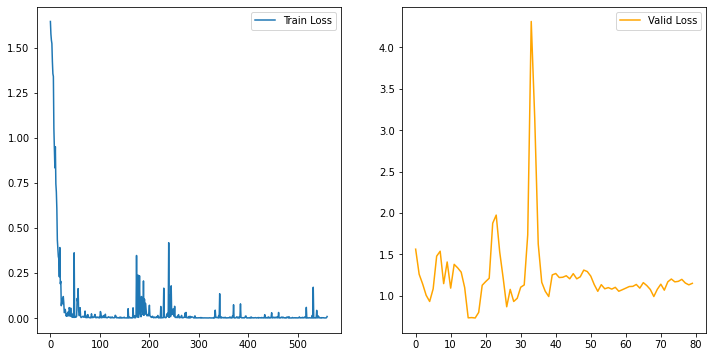

In [ ]:
tl = np.asarray(resnet_50_train_losses).ravel()
vl = np.asarray(resnet_50_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [ ]:
densenet_model_201

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
#DenseNet201
from torchvision.models import densenet201, DenseNet201_Weights
weights = DenseNet201_Weights.DEFAULT
densenet_model_201 = densenet201(weights=weights)
#densenet_model_201 = densenet201()
num_classes = 5
num_ftrs= 1920
densenet_model_201.classifier= nn.Linear(num_ftrs, num_classes)
learning_rate = 2e-4
optimizer = optim.Adam(densenet_model_201.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

In [ ]:
densenet_model_201 = densenet_model_201.to(device)
epochs = 80
loss_fn = nn.CrossEntropyLoss()
densenet_201_train_losses=[]
densenet_201_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%80==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

densenet_model_201 = train(densenet_model_201, loss_fn, train_loader_3d, valid_loader_3d, epochs, optimizer, densenet_201_train_losses, densenet_201_valid_losses, 'drive/Othercomputers/MyPC/R_D/models/densenet201.pth', lr_decay)

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 0.0012906958415572131
Validation loss decreased (-1.000000 --> 0.558609).  Saving model ...


  1%|▏         | 1/80 [00:02<03:14,  2.46s/it]

Epoch - 1 Valid-Loss : 0.5586089491844177 Valid-Accuracy : 0.8518518518518519
Epoch - 2 Train-Loss : 0.0008712641429156065
Validation loss decreased (0.558609 --> 0.554025).  Saving model ...


  2%|▎         | 2/80 [00:04<03:15,  2.50s/it]

Epoch - 2 Valid-Loss : 0.5540248155593872 Valid-Accuracy : 0.8518518518518519


  4%|▍         | 3/80 [00:06<02:39,  2.08s/it]

Epoch - 3 Train-Loss : 0.0007907936981480036
Epoch - 3 Valid-Loss : 0.5637524127960205 Valid-Accuracy : 0.8518518518518519
Epoch - 4 Train-Loss : 0.001673500835230308
Validation loss decreased (0.554025 --> 0.544043).  Saving model ...


  5%|▌         | 4/80 [00:09<02:51,  2.25s/it]

Epoch - 4 Valid-Loss : 0.5440434217453003 Valid-Accuracy : 0.8518518518518519


  6%|▋         | 5/80 [00:10<02:30,  2.00s/it]

Epoch - 5 Train-Loss : 0.003944069055640804
Epoch - 5 Valid-Loss : 0.5706095695495605 Valid-Accuracy : 0.8518518518518519


  8%|▊         | 6/80 [00:12<02:16,  1.84s/it]

Epoch - 6 Train-Loss : 0.0017601374212452875
Epoch - 6 Valid-Loss : 0.6000558137893677 Valid-Accuracy : 0.8518518518518519


  9%|▉         | 7/80 [00:13<02:07,  1.74s/it]

Epoch - 7 Train-Loss : 0.001323228286180113
Epoch - 7 Valid-Loss : 0.5966308116912842 Valid-Accuracy : 0.8518518518518519
Epoch - 8 Train-Loss : 0.001002303116755294
Validation loss decreased (0.544043 --> 0.540255).  Saving model ...


 10%|█         | 8/80 [00:16<02:23,  1.99s/it]

Epoch - 8 Valid-Loss : 0.5402553081512451 Valid-Accuracy : 0.8518518518518519


 11%|█▏        | 9/80 [00:17<02:11,  1.86s/it]

Epoch - 9 Train-Loss : 0.006333580643903198
Epoch - 9 Valid-Loss : 0.5454597473144531 Valid-Accuracy : 0.8518518518518519


 12%|█▎        | 10/80 [00:19<02:02,  1.75s/it]

Epoch - 10 Train-Loss : 0.0030297396754446837
Epoch - 10 Valid-Loss : 0.5664958953857422 Valid-Accuracy : 0.8518518518518519


 14%|█▍        | 11/80 [00:20<01:56,  1.69s/it]

Epoch - 11 Train-Loss : 0.0008871407065141414
Epoch - 11 Valid-Loss : 0.5971762537956238 Valid-Accuracy : 0.8518518518518519


 15%|█▌        | 12/80 [00:22<01:53,  1.67s/it]

Epoch - 12 Train-Loss : 0.0006912105226157499
Epoch - 12 Valid-Loss : 0.5747355222702026 Valid-Accuracy : 0.8518518518518519
Epoch - 13 Train-Loss : 0.005506495234190619
Validation loss decreased (0.540255 --> 0.498630).  Saving model ...


 16%|█▋        | 13/80 [00:25<02:10,  1.95s/it]

Epoch - 13 Valid-Loss : 0.498630166053772 Valid-Accuracy : 0.8518518518518519


 18%|█▊        | 14/80 [00:26<02:00,  1.83s/it]

Epoch - 14 Train-Loss : 0.0011487103848984198
Epoch - 14 Valid-Loss : 0.5365924835205078 Valid-Accuracy : 0.8518518518518519


 19%|█▉        | 15/80 [00:28<01:53,  1.74s/it]

Epoch - 15 Train-Loss : 0.001087284937966615
Epoch - 15 Valid-Loss : 0.5533785223960876 Valid-Accuracy : 0.8518518518518519


 20%|██        | 16/80 [00:29<01:47,  1.68s/it]

Epoch - 16 Train-Loss : 0.0012203106764770513
Epoch - 16 Valid-Loss : 0.6031772494316101 Valid-Accuracy : 0.8148148148148148


 21%|██▏       | 17/80 [00:31<01:42,  1.63s/it]

Epoch - 17 Train-Loss : 0.0017436161620675453
Epoch - 17 Valid-Loss : 0.6074895262718201 Valid-Accuracy : 0.8148148148148148


 22%|██▎       | 18/80 [00:32<01:39,  1.60s/it]

Epoch - 18 Train-Loss : 0.01872613638572927
Epoch - 18 Valid-Loss : 0.6041706204414368 Valid-Accuracy : 0.8148148148148148


 24%|██▍       | 19/80 [00:34<01:36,  1.58s/it]

Epoch - 19 Train-Loss : 0.0033008951868396252
Epoch - 19 Valid-Loss : 0.635607123374939 Valid-Accuracy : 0.8148148148148148


 25%|██▌       | 20/80 [00:35<01:34,  1.58s/it]

Epoch - 20 Train-Loss : 0.0015096288157760032
Epoch - 20 Valid-Loss : 0.605514407157898 Valid-Accuracy : 0.8518518518518519


 26%|██▋       | 21/80 [00:37<01:33,  1.58s/it]

Epoch - 21 Train-Loss : 0.0016305287634687765
Epoch - 21 Valid-Loss : 0.6238783597946167 Valid-Accuracy : 0.8148148148148148


 28%|██▊       | 22/80 [00:38<01:31,  1.57s/it]

Epoch - 22 Train-Loss : 0.0009693421764365796
Epoch - 22 Valid-Loss : 0.5711469054222107 Valid-Accuracy : 0.8518518518518519


 29%|██▉       | 23/80 [00:40<01:28,  1.56s/it]

Epoch - 23 Train-Loss : 0.001034973785863258
Epoch - 23 Valid-Loss : 0.6030144095420837 Valid-Accuracy : 0.8518518518518519


 30%|███       | 24/80 [00:42<01:26,  1.55s/it]

Epoch - 24 Train-Loss : 0.005569143062790057
Epoch - 24 Valid-Loss : 0.5412517786026001 Valid-Accuracy : 0.8518518518518519


 31%|███▏      | 25/80 [00:43<01:24,  1.54s/it]

Epoch - 25 Train-Loss : 0.0005903872619715653
Epoch - 25 Valid-Loss : 0.5355131030082703 Valid-Accuracy : 0.8518518518518519


 32%|███▎      | 26/80 [00:45<01:22,  1.54s/it]

Epoch - 26 Train-Loss : 0.0024763371454485294
Epoch - 26 Valid-Loss : 0.6157613396644592 Valid-Accuracy : 0.8148148148148148


 34%|███▍      | 27/80 [00:46<01:21,  1.54s/it]

Epoch - 27 Train-Loss : 0.0010307902910946204
Epoch - 27 Valid-Loss : 0.6342267394065857 Valid-Accuracy : 0.8148148148148148


 35%|███▌      | 28/80 [00:48<01:19,  1.53s/it]

Epoch - 28 Train-Loss : 0.0004965614934917539
Epoch - 28 Valid-Loss : 0.607846200466156 Valid-Accuracy : 0.8518518518518519


 36%|███▋      | 29/80 [00:49<01:18,  1.53s/it]

Epoch - 29 Train-Loss : 0.000885831075720489
Epoch - 29 Valid-Loss : 0.5640722513198853 Valid-Accuracy : 0.8518518518518519


 38%|███▊      | 30/80 [00:51<01:16,  1.54s/it]

Epoch - 30 Train-Loss : 0.011808434181148186
Epoch - 30 Valid-Loss : 0.6239875555038452 Valid-Accuracy : 0.8518518518518519


 39%|███▉      | 31/80 [00:52<01:15,  1.54s/it]

Epoch - 31 Train-Loss : 0.0009654272538942418
Epoch - 31 Valid-Loss : 0.6249901652336121 Valid-Accuracy : 0.8148148148148148


 40%|████      | 32/80 [00:54<01:13,  1.53s/it]

Epoch - 32 Train-Loss : 0.0007535437346502606
Epoch - 32 Valid-Loss : 0.6182490587234497 Valid-Accuracy : 0.8518518518518519


 41%|████▏     | 33/80 [00:55<01:11,  1.53s/it]

Epoch - 33 Train-Loss : 0.0009469099292930748
Epoch - 33 Valid-Loss : 0.6052736639976501 Valid-Accuracy : 0.8518518518518519


 42%|████▎     | 34/80 [00:57<01:10,  1.53s/it]

Epoch - 34 Train-Loss : 0.0016745290070373034
Epoch - 34 Valid-Loss : 0.6030721068382263 Valid-Accuracy : 0.8148148148148148


 44%|████▍     | 35/80 [00:58<01:08,  1.53s/it]

Epoch - 35 Train-Loss : 0.0015888253110460937
Epoch - 35 Valid-Loss : 0.6002499461174011 Valid-Accuracy : 0.8148148148148148


 45%|████▌     | 36/80 [01:00<01:07,  1.52s/it]

Epoch - 36 Train-Loss : 0.0008702149498276412
Epoch - 36 Valid-Loss : 0.639170229434967 Valid-Accuracy : 0.8148148148148148


 46%|████▋     | 37/80 [01:01<01:05,  1.53s/it]

Epoch - 37 Train-Loss : 0.0006934025233411896
Epoch - 37 Valid-Loss : 0.660155177116394 Valid-Accuracy : 0.8148148148148148


 48%|████▊     | 38/80 [01:03<01:04,  1.52s/it]

Epoch - 38 Train-Loss : 0.01896549435540302
Epoch - 38 Valid-Loss : 0.6387224793434143 Valid-Accuracy : 0.8148148148148148


 49%|████▉     | 39/80 [01:04<01:02,  1.53s/it]

Epoch - 39 Train-Loss : 0.0011074325718384767
Epoch - 39 Valid-Loss : 0.6562633514404297 Valid-Accuracy : 0.8148148148148148


 50%|█████     | 40/80 [01:06<01:01,  1.53s/it]

Epoch - 40 Train-Loss : 0.0007356554685559656
Epoch - 40 Valid-Loss : 0.6224809288978577 Valid-Accuracy : 0.8148148148148148


 51%|█████▏    | 41/80 [01:08<00:59,  1.53s/it]

Epoch - 41 Train-Loss : 0.0029019724461250007
Epoch - 41 Valid-Loss : 0.5443341732025146 Valid-Accuracy : 0.8518518518518519


 52%|█████▎    | 42/80 [01:09<00:58,  1.53s/it]

Epoch - 42 Train-Loss : 0.0009699753053220255
Epoch - 42 Valid-Loss : 0.5499401092529297 Valid-Accuracy : 0.8518518518518519


 54%|█████▍    | 43/80 [01:11<00:56,  1.53s/it]

Epoch - 43 Train-Loss : 0.002081648022535124
Epoch - 43 Valid-Loss : 0.613182544708252 Valid-Accuracy : 0.8518518518518519


 55%|█████▌    | 44/80 [01:12<00:55,  1.53s/it]

Epoch - 44 Train-Loss : 0.002017517840223653
Epoch - 44 Valid-Loss : 0.5817856788635254 Valid-Accuracy : 0.8518518518518519


 56%|█████▋    | 45/80 [01:14<00:53,  1.53s/it]

Epoch - 45 Train-Loss : 0.000977526094564902
Epoch - 45 Valid-Loss : 0.5693587064743042 Valid-Accuracy : 0.8518518518518519


 57%|█████▊    | 46/80 [01:15<00:51,  1.53s/it]

Epoch - 46 Train-Loss : 0.0007496265794283577
Epoch - 46 Valid-Loss : 0.6328879594802856 Valid-Accuracy : 0.8148148148148148


 59%|█████▉    | 47/80 [01:17<00:50,  1.53s/it]

Epoch - 47 Train-Loss : 0.0008826032904575446
Epoch - 47 Valid-Loss : 0.649692952632904 Valid-Accuracy : 0.8148148148148148


 60%|██████    | 48/80 [01:18<00:49,  1.53s/it]

Epoch - 48 Train-Loss : 0.0027125040401837657
Epoch - 48 Valid-Loss : 0.6671016812324524 Valid-Accuracy : 0.8148148148148148


 61%|██████▏   | 49/80 [01:20<00:47,  1.53s/it]

Epoch - 49 Train-Loss : 0.0019827846470954163
Epoch - 49 Valid-Loss : 0.6751635074615479 Valid-Accuracy : 0.8148148148148148


 62%|██████▎   | 50/80 [01:21<00:45,  1.53s/it]

Epoch - 50 Train-Loss : 0.00506979861529544
Epoch - 50 Valid-Loss : 0.6701585054397583 Valid-Accuracy : 0.8148148148148148


 64%|██████▍   | 51/80 [01:23<00:44,  1.52s/it]

Epoch - 51 Train-Loss : 0.0008221935568144545
Epoch - 51 Valid-Loss : 0.579789400100708 Valid-Accuracy : 0.8518518518518519


 65%|██████▌   | 52/80 [01:24<00:42,  1.52s/it]

Epoch - 52 Train-Loss : 0.000854519075281652
Epoch - 52 Valid-Loss : 0.5840107798576355 Valid-Accuracy : 0.8518518518518519


 66%|██████▋   | 53/80 [01:26<00:41,  1.52s/it]

Epoch - 53 Train-Loss : 0.001210663845995441
Epoch - 53 Valid-Loss : 0.5714772343635559 Valid-Accuracy : 0.8518518518518519


 68%|██████▊   | 54/80 [01:27<00:39,  1.53s/it]

Epoch - 54 Train-Loss : 0.0010406471306591161
Epoch - 54 Valid-Loss : 0.6165709495544434 Valid-Accuracy : 0.8148148148148148


 69%|██████▉   | 55/80 [01:29<00:38,  1.53s/it]

Epoch - 55 Train-Loss : 0.001704376149323902
Epoch - 55 Valid-Loss : 0.6509537696838379 Valid-Accuracy : 0.8148148148148148


 70%|███████   | 56/80 [01:30<00:36,  1.53s/it]

Epoch - 56 Train-Loss : 0.0009913754100645228
Epoch - 56 Valid-Loss : 0.6101433634757996 Valid-Accuracy : 0.8518518518518519


 71%|███████▏  | 57/80 [01:32<00:35,  1.53s/it]

Epoch - 57 Train-Loss : 0.0007928650634962001
Epoch - 57 Valid-Loss : 0.6747321486473083 Valid-Accuracy : 0.8148148148148148


 72%|███████▎  | 58/80 [01:34<00:33,  1.53s/it]

Epoch - 58 Train-Loss : 0.0011864029303459184
Epoch - 58 Valid-Loss : 0.5782066583633423 Valid-Accuracy : 0.8518518518518519


 74%|███████▍  | 59/80 [01:35<00:32,  1.53s/it]

Epoch - 59 Train-Loss : 0.002161007490940392
Epoch - 59 Valid-Loss : 0.5669280290603638 Valid-Accuracy : 0.8518518518518519


 75%|███████▌  | 60/80 [01:37<00:30,  1.53s/it]

Epoch - 60 Train-Loss : 0.0009238419256040028
Epoch - 60 Valid-Loss : 0.6260507106781006 Valid-Accuracy : 0.8518518518518519


 76%|███████▋  | 61/80 [01:38<00:29,  1.54s/it]

Epoch - 61 Train-Loss : 0.0007943939833369638
Epoch - 61 Valid-Loss : 0.6111192107200623 Valid-Accuracy : 0.8148148148148148


 78%|███████▊  | 62/80 [01:40<00:27,  1.53s/it]

Epoch - 62 Train-Loss : 0.0027289745963311623
Epoch - 62 Valid-Loss : 0.5746192336082458 Valid-Accuracy : 0.8518518518518519


 79%|███████▉  | 63/80 [01:41<00:26,  1.53s/it]

Epoch - 63 Train-Loss : 0.0016869131276117904
Epoch - 63 Valid-Loss : 0.5492761135101318 Valid-Accuracy : 0.8518518518518519


 80%|████████  | 64/80 [01:43<00:24,  1.53s/it]

Epoch - 64 Train-Loss : 0.010357419735685523
Epoch - 64 Valid-Loss : 0.6308589577674866 Valid-Accuracy : 0.8148148148148148


 81%|████████▏ | 65/80 [01:44<00:23,  1.54s/it]

Epoch - 65 Train-Loss : 0.000949855415715969
Epoch - 65 Valid-Loss : 0.6204783320426941 Valid-Accuracy : 0.8518518518518519


 82%|████████▎ | 66/80 [01:46<00:21,  1.54s/it]

Epoch - 66 Train-Loss : 0.003376968575009544
Epoch - 66 Valid-Loss : 0.6244933009147644 Valid-Accuracy : 0.8148148148148148


 84%|████████▍ | 67/80 [01:47<00:19,  1.53s/it]

Epoch - 67 Train-Loss : 0.0010670907670698529
Epoch - 67 Valid-Loss : 0.5709111094474792 Valid-Accuracy : 0.8518518518518519


 85%|████████▌ | 68/80 [01:49<00:18,  1.53s/it]

Epoch - 68 Train-Loss : 0.008106078965023958
Epoch - 68 Valid-Loss : 0.6513318419456482 Valid-Accuracy : 0.8148148148148148


 86%|████████▋ | 69/80 [01:50<00:16,  1.53s/it]

Epoch - 69 Train-Loss : 0.019311056218741993
Epoch - 69 Valid-Loss : 0.592624306678772 Valid-Accuracy : 0.8518518518518519


 88%|████████▊ | 70/80 [01:52<00:15,  1.54s/it]

Epoch - 70 Train-Loss : 0.0026063113348625067
Epoch - 70 Valid-Loss : 0.5590692758560181 Valid-Accuracy : 0.8518518518518519


 89%|████████▉ | 71/80 [01:53<00:13,  1.54s/it]

Epoch - 71 Train-Loss : 0.001475778570498473
Epoch - 71 Valid-Loss : 0.5656161308288574 Valid-Accuracy : 0.8518518518518519


 90%|█████████ | 72/80 [01:55<00:12,  1.54s/it]

Epoch - 72 Train-Loss : 0.0009279145368574453
Epoch - 72 Valid-Loss : 0.6241334080696106 Valid-Accuracy : 0.8518518518518519


 91%|█████████▏| 73/80 [01:57<00:10,  1.53s/it]

Epoch - 73 Train-Loss : 0.0015279328799806535
Epoch - 73 Valid-Loss : 0.5989307165145874 Valid-Accuracy : 0.8148148148148148


 92%|█████████▎| 74/80 [01:58<00:09,  1.53s/it]

Epoch - 74 Train-Loss : 0.002713521510096533
Epoch - 74 Valid-Loss : 0.540667712688446 Valid-Accuracy : 0.8518518518518519


 94%|█████████▍| 75/80 [02:00<00:07,  1.54s/it]

Epoch - 75 Train-Loss : 0.0014271756933469857
Epoch - 75 Valid-Loss : 0.5554539561271667 Valid-Accuracy : 0.8518518518518519


 95%|█████████▌| 76/80 [02:01<00:06,  1.54s/it]

Epoch - 76 Train-Loss : 0.003501688055361488
Epoch - 76 Valid-Loss : 0.5666201710700989 Valid-Accuracy : 0.8518518518518519


 96%|█████████▋| 77/80 [02:03<00:04,  1.54s/it]

Epoch - 77 Train-Loss : 0.0010446953861641564
Epoch - 77 Valid-Loss : 0.6312043070793152 Valid-Accuracy : 0.8518518518518519


 98%|█████████▊| 78/80 [02:04<00:03,  1.54s/it]

Epoch - 78 Train-Loss : 0.0008886014901301158
Epoch - 78 Valid-Loss : 0.5773963332176208 Valid-Accuracy : 0.8518518518518519


 99%|█████████▉| 79/80 [02:06<00:01,  1.53s/it]

Epoch - 79 Train-Loss : 0.0012498758608541851
Epoch - 79 Valid-Loss : 0.5431170463562012 Valid-Accuracy : 0.8518518518518519
Changed learning rate to 2e-12


100%|██████████| 80/80 [02:07<00:00,  1.60s/it]

Epoch - 80 Train-Loss : 0.0014204236046810234
Epoch - 80 Valid-Loss : 0.5287206172943115 Valid-Accuracy : 0.8518518518518519


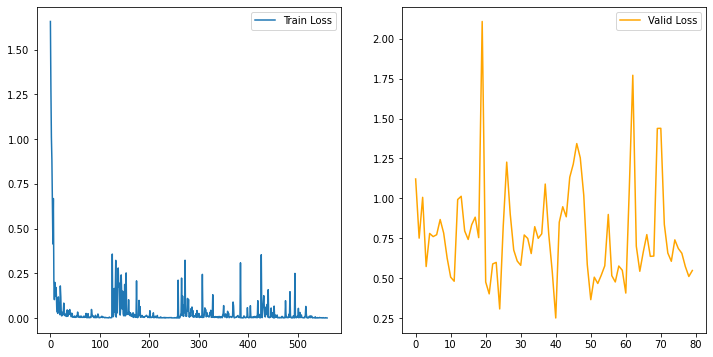

In [ ]:
tl = np.asarray(densenet_201_train_losses).ravel()
vl = np.asarray(densenet_201_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [ ]:
efficientnet_model_b7

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
#EfficientNet
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights
weights = EfficientNet_V2_L_Weights.DEFAULT
efficientnet_model_b7 = efficientnet_v2_l(weights=weights)
# efficientnet_b7_model = efficientnet_v2_l()
num_classes = 5
num_ftrs= 1280
efficientnet_model_b7.classifier[1]= nn.Linear(num_ftrs, num_classes)
learning_rate = 2e-5
optimizer = optim.Adam(efficientnet_model_b7.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth


  0%|          | 0.00/455M [00:00<?, ?B/s]

In [ ]:
efficientnet_model_b7 = efficientnet_model_b7.to(device)
epochs = 80
loss_fn = nn.CrossEntropyLoss()
efficientnet_b7_train_losses=[]
efficientnet_b7_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%100==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

efficientnet_b7_model = train(efficientnet_model_b7, loss_fn, train_loader_3d, valid_loader_3d, epochs, optimizer, efficientnet_b7_train_losses, efficientnet_b7_valid_losses, 'drive/Othercomputers/MyPC/R_D/models/efficientnet_b7.pth', lr_decay) 

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 1.616263014929635
Validation loss decreased (-1.000000 --> 1.576217).  Saving model ...


  1%|▏         | 1/80 [00:09<11:58,  9.09s/it]

Epoch - 1 Valid-Loss : 1.5762170553207397 Valid-Accuracy : 0.2222222222222222


  2%|▎         | 2/80 [00:11<06:43,  5.17s/it]

Epoch - 2 Train-Loss : 1.2938914128712244
Epoch - 2 Valid-Loss : 1.616522192955017 Valid-Accuracy : 0.18518518518518517
Epoch - 3 Train-Loss : 1.083714016846248
Validation loss decreased (1.576217 --> 1.220294).  Saving model ...


  4%|▍         | 3/80 [00:17<07:22,  5.75s/it]

Epoch - 3 Valid-Loss : 1.2202942371368408 Valid-Accuracy : 0.6296296296296297
Epoch - 4 Train-Loss : 0.8313839094979423
Validation loss decreased (1.220294 --> 1.075771).  Saving model ...


  5%|▌         | 4/80 [00:25<08:14,  6.50s/it]

Epoch - 4 Valid-Loss : 1.075771450996399 Valid-Accuracy : 0.7777777777777778
Epoch - 5 Train-Loss : 0.7024282387324742
Validation loss decreased (1.075771 --> 0.983302).  Saving model ...


  6%|▋         | 5/80 [00:33<08:48,  7.05s/it]

Epoch - 5 Valid-Loss : 0.9833019971847534 Valid-Accuracy : 0.8888888888888888
Epoch - 6 Train-Loss : 0.5567210486957005
Validation loss decreased (0.983302 --> 0.903166).  Saving model ...


  8%|▊         | 6/80 [00:41<09:00,  7.31s/it]

Epoch - 6 Valid-Loss : 0.9031658172607422 Valid-Accuracy : 0.8888888888888888
Epoch - 7 Train-Loss : 0.42925591128213064
Validation loss decreased (0.903166 --> 0.853843).  Saving model ...


  9%|▉         | 7/80 [00:48<08:36,  7.08s/it]

Epoch - 7 Valid-Loss : 0.8538426756858826 Valid-Accuracy : 0.8518518518518519
Epoch - 8 Train-Loss : 0.37984780754361835
Validation loss decreased (0.853843 --> 0.798353).  Saving model ...


 10%|█         | 8/80 [00:54<08:18,  6.93s/it]

Epoch - 8 Valid-Loss : 0.7983534336090088 Valid-Accuracy : 0.8888888888888888
Epoch - 9 Train-Loss : 0.2961807485137667
Validation loss decreased (0.798353 --> 0.723496).  Saving model ...


 11%|█▏        | 9/80 [01:01<08:02,  6.80s/it]

Epoch - 9 Valid-Loss : 0.7234955430030823 Valid-Accuracy : 0.8888888888888888
Epoch - 10 Train-Loss : 0.26329577394894194
Validation loss decreased (0.723496 --> 0.688685).  Saving model ...


 12%|█▎        | 10/80 [01:07<07:47,  6.68s/it]

Epoch - 10 Valid-Loss : 0.6886851191520691 Valid-Accuracy : 0.8888888888888888
Epoch - 11 Train-Loss : 0.21472022150244033
Validation loss decreased (0.688685 --> 0.634745).  Saving model ...


 14%|█▍        | 11/80 [01:14<07:37,  6.63s/it]

Epoch - 11 Valid-Loss : 0.6347454190254211 Valid-Accuracy : 0.8888888888888888
Epoch - 12 Train-Loss : 0.16667104193142482
Validation loss decreased (0.634745 --> 0.596731).  Saving model ...


 15%|█▌        | 12/80 [01:20<07:28,  6.60s/it]

Epoch - 12 Valid-Loss : 0.5967309474945068 Valid-Accuracy : 0.8888888888888888
Epoch - 13 Train-Loss : 0.14866294818265097
Validation loss decreased (0.596731 --> 0.567746).  Saving model ...


 16%|█▋        | 13/80 [01:27<07:23,  6.61s/it]

Epoch - 13 Valid-Loss : 0.5677457451820374 Valid-Accuracy : 0.8888888888888888
Epoch - 14 Train-Loss : 0.12264394866568702
Validation loss decreased (0.567746 --> 0.551939).  Saving model ...


 18%|█▊        | 14/80 [01:35<07:40,  6.98s/it]

Epoch - 14 Valid-Loss : 0.5519387125968933 Valid-Accuracy : 0.8518518518518519
Epoch - 15 Train-Loss : 0.10450087487697601
Validation loss decreased (0.551939 --> 0.516152).  Saving model ...


 19%|█▉        | 15/80 [01:43<07:53,  7.28s/it]

Epoch - 15 Valid-Loss : 0.5161522626876831 Valid-Accuracy : 0.8888888888888888
Epoch - 16 Train-Loss : 0.09275841393641063
Validation loss decreased (0.516152 --> 0.504216).  Saving model ...


 20%|██        | 16/80 [01:50<07:47,  7.31s/it]

Epoch - 16 Valid-Loss : 0.5042162537574768 Valid-Accuracy : 0.8518518518518519
Epoch - 17 Train-Loss : 0.07920239706124578
Validation loss decreased (0.504216 --> 0.477215).  Saving model ...


 21%|██▏       | 17/80 [01:57<07:26,  7.09s/it]

Epoch - 17 Valid-Loss : 0.4772147536277771 Valid-Accuracy : 0.8888888888888888
Epoch - 18 Train-Loss : 0.07797845772334508
Validation loss decreased (0.477215 --> 0.462267).  Saving model ...


 22%|██▎       | 18/80 [02:03<07:11,  6.96s/it]

Epoch - 18 Valid-Loss : 0.46226727962493896 Valid-Accuracy : 0.8888888888888888
Epoch - 19 Train-Loss : 0.061419260288987844
Validation loss decreased (0.462267 --> 0.454576).  Saving model ...


 24%|██▍       | 19/80 [02:11<07:16,  7.15s/it]

Epoch - 19 Valid-Loss : 0.4545764923095703 Valid-Accuracy : 0.8518518518518519
Epoch - 20 Train-Loss : 0.19474338686891965
Validation loss decreased (0.454576 --> 0.439990).  Saving model ...


 25%|██▌       | 20/80 [02:19<07:22,  7.37s/it]

Epoch - 20 Valid-Loss : 0.4399900436401367 Valid-Accuracy : 0.8888888888888888


 26%|██▋       | 21/80 [02:21<05:43,  5.83s/it]

Epoch - 21 Train-Loss : 0.04933244442301137
Epoch - 21 Valid-Loss : 0.44768813252449036 Valid-Accuracy : 0.8888888888888888


 28%|██▊       | 22/80 [02:23<04:35,  4.75s/it]

Epoch - 22 Train-Loss : 0.04933550235416208
Epoch - 22 Valid-Loss : 0.4536188840866089 Valid-Accuracy : 0.8888888888888888
Epoch - 23 Train-Loss : 0.06793961780411857
Validation loss decreased (0.439990 --> 0.438767).  Saving model ...


 29%|██▉       | 23/80 [02:30<05:06,  5.38s/it]

Epoch - 23 Valid-Loss : 0.4387669861316681 Valid-Accuracy : 0.8888888888888888
Epoch - 24 Train-Loss : 0.03491813024239881
Validation loss decreased (0.438767 --> 0.424571).  Saving model ...


 30%|███       | 24/80 [02:36<05:19,  5.70s/it]

Epoch - 24 Valid-Loss : 0.4245705008506775 Valid-Accuracy : 0.8518518518518519
Epoch - 25 Train-Loss : 0.043451842452798574
Validation loss decreased (0.424571 --> 0.418134).  Saving model ...


 31%|███▏      | 25/80 [02:45<05:55,  6.47s/it]

Epoch - 25 Valid-Loss : 0.41813385486602783 Valid-Accuracy : 0.8888888888888888
Epoch - 26 Train-Loss : 0.03703440007354532
Validation loss decreased (0.418134 --> 0.394549).  Saving model ...


 32%|███▎      | 26/80 [02:52<06:10,  6.86s/it]

Epoch - 26 Valid-Loss : 0.39454883337020874 Valid-Accuracy : 0.8888888888888888


 34%|███▍      | 27/80 [02:55<04:50,  5.48s/it]

Epoch - 27 Train-Loss : 0.04393002377556903
Epoch - 27 Valid-Loss : 0.4020101726055145 Valid-Accuracy : 0.8888888888888888
Epoch - 28 Train-Loss : 0.031190390698611736
Validation loss decreased (0.394549 --> 0.388631).  Saving model ...


 35%|███▌      | 28/80 [03:01<04:59,  5.76s/it]

Epoch - 28 Valid-Loss : 0.3886314630508423 Valid-Accuracy : 0.9259259259259259
Epoch - 29 Train-Loss : 0.022505664665784155
Validation loss decreased (0.388631 --> 0.367561).  Saving model ...


 36%|███▋      | 29/80 [03:08<05:13,  6.14s/it]

Epoch - 29 Valid-Loss : 0.36756062507629395 Valid-Accuracy : 0.9259259259259259


 38%|███▊      | 30/80 [03:11<04:10,  5.01s/it]

Epoch - 30 Train-Loss : 0.04092042866562094
Epoch - 30 Valid-Loss : 0.36942943930625916 Valid-Accuracy : 0.8888888888888888
Epoch - 31 Train-Loss : 0.025495474825480154
Validation loss decreased (0.367561 --> 0.355215).  Saving model ...


 39%|███▉      | 31/80 [03:17<04:27,  5.46s/it]

Epoch - 31 Valid-Loss : 0.3552154004573822 Valid-Accuracy : 0.8888888888888888


 40%|████      | 32/80 [03:19<03:36,  4.50s/it]

Epoch - 32 Train-Loss : 0.03501808576818023
Epoch - 32 Valid-Loss : 0.36355137825012207 Valid-Accuracy : 0.8888888888888888
Epoch - 33 Train-Loss : 0.031623548961111476
Validation loss decreased (0.355215 --> 0.327266).  Saving model ...


 41%|████▏     | 33/80 [03:26<04:00,  5.11s/it]

Epoch - 33 Valid-Loss : 0.32726559042930603 Valid-Accuracy : 0.8888888888888888
Epoch - 34 Train-Loss : 0.03378249418788722
Validation loss decreased (0.327266 --> 0.304351).  Saving model ...


 42%|████▎     | 34/80 [03:32<04:16,  5.57s/it]

Epoch - 34 Valid-Loss : 0.3043510913848877 Valid-Accuracy : 0.9259259259259259
Epoch - 35 Train-Loss : 0.022274159560246126
Validation loss decreased (0.304351 --> 0.296839).  Saving model ...


 44%|████▍     | 35/80 [03:40<04:43,  6.30s/it]

Epoch - 35 Valid-Loss : 0.29683855175971985 Valid-Accuracy : 0.9259259259259259


 45%|████▌     | 36/80 [03:43<03:44,  5.09s/it]

Epoch - 36 Train-Loss : 0.018927861404206072
Epoch - 36 Valid-Loss : 0.30621686577796936 Valid-Accuracy : 0.9259259259259259


 46%|████▋     | 37/80 [03:45<03:02,  4.25s/it]

Epoch - 37 Train-Loss : 0.022837258675800904
Epoch - 37 Valid-Loss : 0.31498298048973083 Valid-Accuracy : 0.9259259259259259


 48%|████▊     | 38/80 [03:47<02:33,  3.65s/it]

Epoch - 38 Train-Loss : 0.01840202896190541
Epoch - 38 Valid-Loss : 0.31558316946029663 Valid-Accuracy : 0.9259259259259259


 49%|████▉     | 39/80 [03:50<02:14,  3.27s/it]

Epoch - 39 Train-Loss : 0.024037313048860857
Epoch - 39 Valid-Loss : 0.3186575472354889 Valid-Accuracy : 0.9259259259259259


 50%|█████     | 40/80 [03:52<02:00,  3.02s/it]

Epoch - 40 Train-Loss : 0.025525434674429043
Epoch - 40 Valid-Loss : 0.3190009891986847 Valid-Accuracy : 0.9259259259259259


 51%|█████▏    | 41/80 [03:54<01:49,  2.81s/it]

Epoch - 41 Train-Loss : 0.010452586359211377
Epoch - 41 Valid-Loss : 0.33275240659713745 Valid-Accuracy : 0.8888888888888888


 52%|█████▎    | 42/80 [03:57<01:41,  2.66s/it]

Epoch - 42 Train-Loss : 0.027308615323688303
Epoch - 42 Valid-Loss : 0.34234294295310974 Valid-Accuracy : 0.8888888888888888


 54%|█████▍    | 43/80 [03:59<01:34,  2.55s/it]

Epoch - 43 Train-Loss : 0.03196201513388327
Epoch - 43 Valid-Loss : 0.30790501832962036 Valid-Accuracy : 0.9259259259259259


 55%|█████▌    | 44/80 [04:01<01:28,  2.46s/it]

Epoch - 44 Train-Loss : 0.031131364604724304
Epoch - 44 Valid-Loss : 0.3668966591358185 Valid-Accuracy : 0.8888888888888888


 56%|█████▋    | 45/80 [04:04<01:23,  2.39s/it]

Epoch - 45 Train-Loss : 0.021990058211875812
Epoch - 45 Valid-Loss : 0.4018682539463043 Valid-Accuracy : 0.8148148148148148


 57%|█████▊    | 46/80 [04:06<01:19,  2.34s/it]

Epoch - 46 Train-Loss : 0.02287677855097822
Epoch - 46 Valid-Loss : 0.37715280055999756 Valid-Accuracy : 0.8888888888888888


 59%|█████▉    | 47/80 [04:08<01:16,  2.31s/it]

Epoch - 47 Train-Loss : 0.028104268945753574
Epoch - 47 Valid-Loss : 0.3741798400878906 Valid-Accuracy : 0.9259259259259259


 60%|██████    | 48/80 [04:10<01:13,  2.29s/it]

Epoch - 48 Train-Loss : 0.0210302334411868
Epoch - 48 Valid-Loss : 0.3831195533275604 Valid-Accuracy : 0.9259259259259259


 61%|██████▏   | 49/80 [04:12<01:10,  2.27s/it]

Epoch - 49 Train-Loss : 0.02469739517463105
Epoch - 49 Valid-Loss : 0.35822901129722595 Valid-Accuracy : 0.9259259259259259


 62%|██████▎   | 50/80 [04:15<01:07,  2.26s/it]

Epoch - 50 Train-Loss : 0.016878996842673848
Epoch - 50 Valid-Loss : 0.37925416231155396 Valid-Accuracy : 0.9259259259259259


 64%|██████▍   | 51/80 [04:17<01:05,  2.25s/it]

Epoch - 51 Train-Loss : 0.01590168915156807
Epoch - 51 Valid-Loss : 0.356206476688385 Valid-Accuracy : 0.8888888888888888


 65%|██████▌   | 52/80 [04:19<01:02,  2.25s/it]

Epoch - 52 Train-Loss : 0.02191829974097865
Epoch - 52 Valid-Loss : 0.34288495779037476 Valid-Accuracy : 0.8888888888888888


 66%|██████▋   | 53/80 [04:21<01:00,  2.24s/it]

Epoch - 53 Train-Loss : 0.011038194876164198
Epoch - 53 Valid-Loss : 0.3184162676334381 Valid-Accuracy : 0.9259259259259259


 68%|██████▊   | 54/80 [04:24<00:58,  2.23s/it]

Epoch - 54 Train-Loss : 0.02436089439184538
Epoch - 54 Valid-Loss : 0.3292633593082428 Valid-Accuracy : 0.8888888888888888


 69%|██████▉   | 55/80 [04:26<00:55,  2.23s/it]

Epoch - 55 Train-Loss : 0.024030340003914068
Epoch - 55 Valid-Loss : 0.31337833404541016 Valid-Accuracy : 0.9259259259259259


 70%|███████   | 56/80 [04:28<00:53,  2.23s/it]

Epoch - 56 Train-Loss : 0.01756796513551048
Epoch - 56 Valid-Loss : 0.3327438533306122 Valid-Accuracy : 0.8888888888888888


 71%|███████▏  | 57/80 [04:30<00:51,  2.23s/it]

Epoch - 57 Train-Loss : 0.013151744047978095
Epoch - 57 Valid-Loss : 0.34157779812812805 Valid-Accuracy : 0.8888888888888888


 72%|███████▎  | 58/80 [04:32<00:49,  2.23s/it]

Epoch - 58 Train-Loss : 0.011065056148384298
Epoch - 58 Valid-Loss : 0.34322699904441833 Valid-Accuracy : 0.8888888888888888


 74%|███████▍  | 59/80 [04:35<00:47,  2.26s/it]

Epoch - 59 Train-Loss : 0.01640486218301313
Epoch - 59 Valid-Loss : 0.33201509714126587 Valid-Accuracy : 0.8888888888888888


 75%|███████▌  | 60/80 [04:37<00:45,  2.25s/it]

Epoch - 60 Train-Loss : 0.022146995179355145
Epoch - 60 Valid-Loss : 0.3532465398311615 Valid-Accuracy : 0.8888888888888888


 76%|███████▋  | 61/80 [04:39<00:42,  2.24s/it]

Epoch - 61 Train-Loss : 0.040550280595198274
Epoch - 61 Valid-Loss : 0.4264090955257416 Valid-Accuracy : 0.8148148148148148


 78%|███████▊  | 62/80 [04:42<00:40,  2.24s/it]

Epoch - 62 Train-Loss : 0.01170171981876982
Epoch - 62 Valid-Loss : 0.4568853974342346 Valid-Accuracy : 0.8148148148148148


 79%|███████▉  | 63/80 [04:44<00:37,  2.23s/it]

Epoch - 63 Train-Loss : 0.04138015589809844
Epoch - 63 Valid-Loss : 0.42985421419143677 Valid-Accuracy : 0.8888888888888888


 80%|████████  | 64/80 [04:46<00:35,  2.23s/it]

Epoch - 64 Train-Loss : 0.03318405530548522
Epoch - 64 Valid-Loss : 0.3775172829627991 Valid-Accuracy : 0.8888888888888888


 81%|████████▏ | 65/80 [04:48<00:33,  2.23s/it]

Epoch - 65 Train-Loss : 0.019458803747381483
Epoch - 65 Valid-Loss : 0.3669498860836029 Valid-Accuracy : 0.8518518518518519


 82%|████████▎ | 66/80 [04:50<00:31,  2.23s/it]

Epoch - 66 Train-Loss : 0.011830047737540943
Epoch - 66 Valid-Loss : 0.37564221024513245 Valid-Accuracy : 0.8518518518518519


 84%|████████▍ | 67/80 [04:53<00:28,  2.23s/it]

Epoch - 67 Train-Loss : 0.011408285703510046
Epoch - 67 Valid-Loss : 0.37842515110969543 Valid-Accuracy : 0.8518518518518519


 85%|████████▌ | 68/80 [04:55<00:26,  2.23s/it]

Epoch - 68 Train-Loss : 0.015855761178370033
Epoch - 68 Valid-Loss : 0.38246282935142517 Valid-Accuracy : 0.8518518518518519


 86%|████████▋ | 69/80 [04:57<00:24,  2.23s/it]

Epoch - 69 Train-Loss : 0.013658728184444564
Epoch - 69 Valid-Loss : 0.3444630801677704 Valid-Accuracy : 0.8518518518518519


 88%|████████▊ | 70/80 [04:59<00:22,  2.23s/it]

Epoch - 70 Train-Loss : 0.01557270806681897
Epoch - 70 Valid-Loss : 0.38982030749320984 Valid-Accuracy : 0.8518518518518519


 89%|████████▉ | 71/80 [05:02<00:20,  2.23s/it]

Epoch - 71 Train-Loss : 0.03849685434917254
Epoch - 71 Valid-Loss : 0.3828836679458618 Valid-Accuracy : 0.8518518518518519


 90%|█████████ | 72/80 [05:04<00:17,  2.23s/it]

Epoch - 72 Train-Loss : 0.02893536108812051
Epoch - 72 Valid-Loss : 0.41102293133735657 Valid-Accuracy : 0.8518518518518519


 91%|█████████▏| 73/80 [05:06<00:15,  2.23s/it]

Epoch - 73 Train-Loss : 0.007840342187721814
Epoch - 73 Valid-Loss : 0.33662179112434387 Valid-Accuracy : 0.9259259259259259
Epoch - 74 Train-Loss : 0.01495904162792223
Validation loss decreased (0.296839 --> 0.292878).  Saving model ...


 92%|█████████▎| 74/80 [05:12<00:20,  3.49s/it]

Epoch - 74 Valid-Loss : 0.29287824034690857 Valid-Accuracy : 0.8888888888888888


 94%|█████████▍| 75/80 [05:15<00:15,  3.12s/it]

Epoch - 75 Train-Loss : 0.008285712018342955
Epoch - 75 Valid-Loss : 0.31159690022468567 Valid-Accuracy : 0.8888888888888888
Epoch - 76 Train-Loss : 0.04770614585972258
Validation loss decreased (0.292878 --> 0.270581).  Saving model ...


 95%|█████████▌| 76/80 [05:21<00:16,  4.19s/it]

Epoch - 76 Valid-Loss : 0.2705811858177185 Valid-Accuracy : 0.9259259259259259


 96%|█████████▋| 77/80 [05:24<00:10,  3.61s/it]

Epoch - 77 Train-Loss : 0.011010444024577737
Epoch - 77 Valid-Loss : 0.27385708689689636 Valid-Accuracy : 0.9259259259259259


 98%|█████████▊| 78/80 [05:26<00:06,  3.20s/it]

Epoch - 78 Train-Loss : 0.054040513067905395
Epoch - 78 Valid-Loss : 0.29561662673950195 Valid-Accuracy : 0.9259259259259259


 99%|█████████▉| 79/80 [05:28<00:02,  2.91s/it]

Epoch - 79 Train-Loss : 0.00609358779287764
Epoch - 79 Valid-Loss : 0.30521008372306824 Valid-Accuracy : 0.8888888888888888


100%|██████████| 80/80 [05:30<00:00,  4.14s/it]

Epoch - 80 Train-Loss : 0.004859895678237081
Epoch - 80 Valid-Loss : 0.323609858751297 Valid-Accuracy : 0.8518518518518519


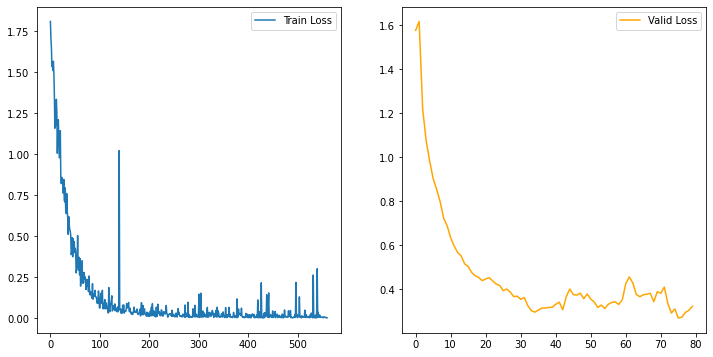

In [ ]:
tl = np.asarray(efficientnet_b7_train_losses).ravel()
vl = np.asarray(efficientnet_b7_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


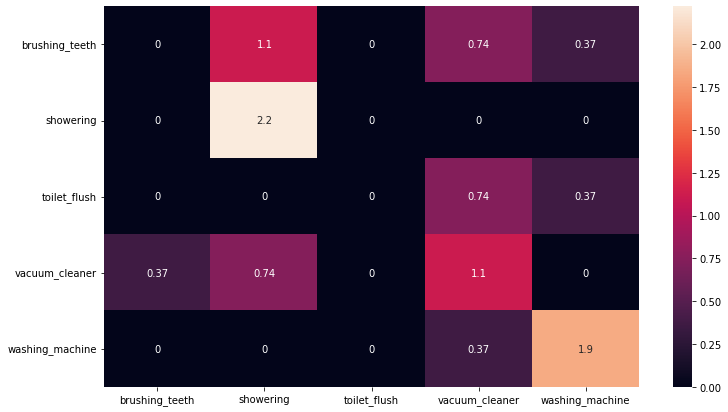

In [ ]:
#for VGG
model_net = vgg_model_19
show_heatmap(valid_loader_3d, model_net)

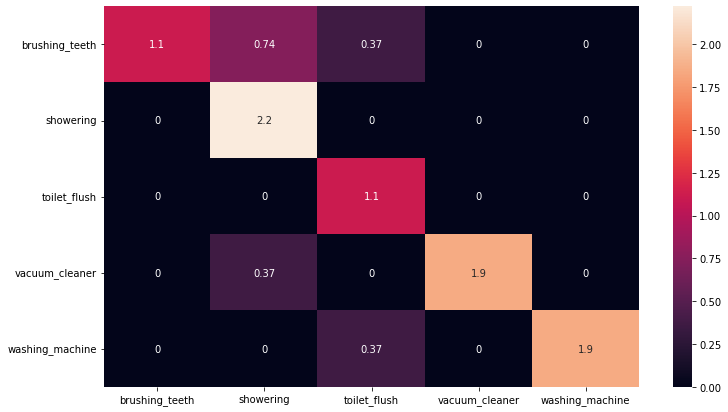

In [ ]:
#for alexnet
model_net = alexnet_model
show_heatmap(valid_loader_3d, model_net)

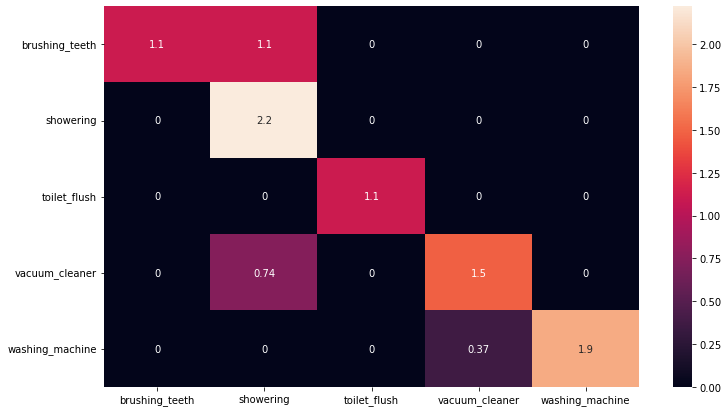

In [ ]:
#for resnet_152
model_net = resnet_model_152
show_heatmap(valid_loader_3d, model_net)

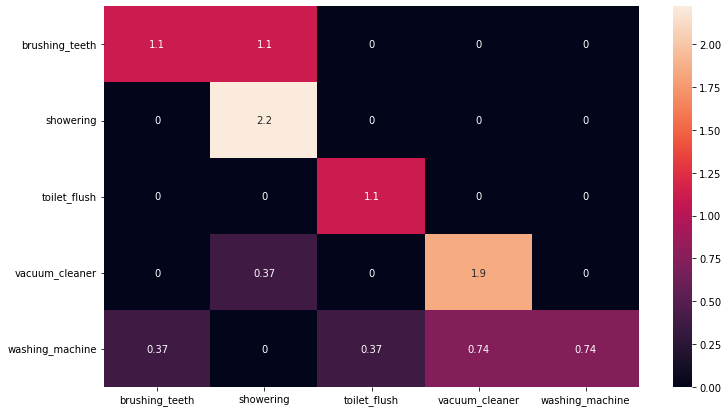

In [ ]:
#for resnet_50
model_net = resnet_model_50
show_heatmap(valid_loader_3d, model_net)

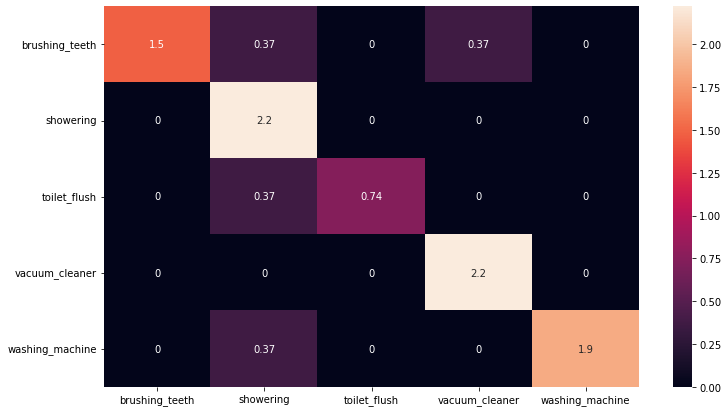

In [ ]:
#for densenet201
model_net = densenet_model_201
show_heatmap(valid_loader_3d, model_net)

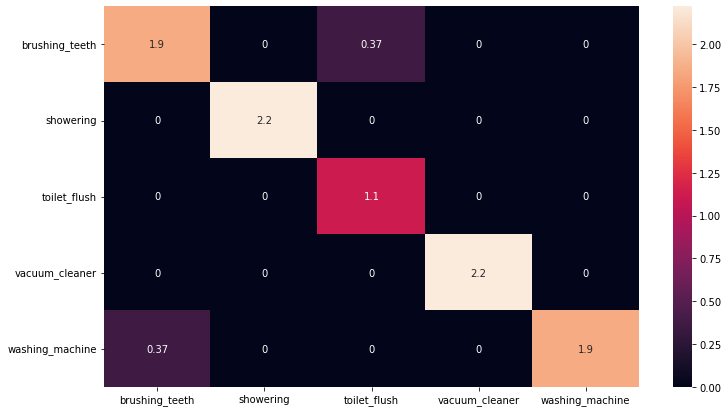

In [ ]:
#for efficientnet_b7
model_net = efficientnet_model_b7
show_heatmap(valid_loader_3d, model_net)

In [ ]:
torch.save(custom_model, './models/custom_model.pth')

In [ ]:
torch.save(resnet_model_152, './models/resnet152.pth')

In [ ]:
torch.save(resnet_model_50, './models/resnet50.pth')

In [ ]:
torch.save(densenet_model_201, './models/densenet201.pth')

In [ ]:
torch.save(efficientnet_b7_model, './models/efficentnet_b7.pth')

In [ ]:
torch.save(vgg_model_19, './models/vgg_19.pth')

In [ ]:
custom_model, optimizer = load_ckp(prefix + './models/custom_model.pth', custom_model, optimizer)
custom_model.eval()

In [ ]:
vgg_model_19, optimizer= load_ckp(prefix + './models/vgg_19.pth', vgg_model_19, optimizer)
vgg_model_19.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
alexnet, optimizer= load_ckp(prefix + './models/alexnet.pth', alexnet_model, optimizer)
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
resnet_model_152, optimizer= load_ckp(prefix + './models/resnet152.pth', resnet_model_152, optimizer)
resnet_model_152.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
resnet_model_50, optimizer= load_ckp(prefix + './models/resnet50.pth', resnet_model_50, optimizer)
resnet_model_50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
densenet_model_201, optimizer= load_ckp(prefix + './models/densenet201.pth', densenet_model_201, optimizer)
densenet_model_201.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
efficientnet_model_b7, optimizer= load_ckp(prefix + './models/efficientnet_b7.pth', efficientnet_model_b7, optimizer)
efficientnet_model_b7.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
def show_heatmap_3d(testloader, net):
    y_pred = []
    y_true = []
    net= net.to(device)
    
    # iterate over test data
    for labels, inputs in enumerate(testloader):
        
            x, y = inputs
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            output = net(x)       

            # output = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
            print (output)
            output= (torch.max(torch.exp(output), 1)[1]).cpu().detach().numpy()
            print (output)
            y_pred.extend(output) # Save Prediction
            labels = valid_data_3d.labels
            y_true.extend(labels) # Save Truth

    print ("Pred: ", output)
    print ("Real: ", valid_data_3d.labels)

    # constant for classes
    classes = ('brushing_teeth', 'showering', 'toilet_flush', 'vacuum_cleaner', 'washing_machine')
    # classes = ('brushing_teeth', 'toilet_flush', 'vacuum_cleaner')
    
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)

In [ ]:
def show_heatmap(testloader, net):
    trace_yhat = []
    trace_y = []
    net= net.to(device)
    
    # iterate over test data
    for labels, inputs in enumerate(testloader):
        
            x, y = inputs
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = net(x)        

            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy().argmax(axis=1))      
            trace_y = np.concatenate(trace_y)
            trace_yhat = np.concatenate(trace_yhat)

    # constant for classes
    classes = ('brushing_teeth', 'showering', 'toilet_flush', 'vacuum_cleaner', 'washing_machine')

    # Build confusion matrix
    cf_matrix = confusion_matrix(trace_y, trace_yhat)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)

In [ ]:
categories = sorted(df['category'].unique())
categories

['brushing_teeth', 'toilet_flush', 'vacuum_cleaner', 'washing_machine']

In [ ]:
# with open('indtocat.pkl','rb') as f:
#     indtocat = pickle.load(f)
filename= prefix +'./audio/6-100001-A-1.wav'
spec=spec_to_image_3d(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
print (spec_t.shape)
spec_t= spec_t.permute(2, 0 ,1)
spec_t= spec_t.reshape(1, 3, 128, 431)
print (spec_t.shape)
pr=efficientnet_model_b7.forward(spec_t)
print (pr)
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
# ind = (torch.max(torch.exp(pr), 1)[1]).data.cpu().numpy()
# print(indtocat[ind])
print (ind)
IPython.display.display(IPython.display.Audio(filename=filename))

torch.Size([128, 431, 3])
torch.Size([1, 3, 128, 431])
tensor([[-3.0396,  0.7060,  3.9262, -0.1178, -1.2492]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
2
